In [1]:
import sys
sys.path.append('C:\\projects\\UTNCE\\src\\utnce202402')

In [2]:
from simplify import *
from prepare_yssp import *
from routing_yssp import *
from percolation_plot import *
from generate_yssp import *
from transfer_yssp import *
from copy import deepcopy
from shapely.geometry import Point,LineString
from pyproj import Proj, Transformer
import pickle
import itertools
from itertools import combinations
import random
from sympy import symbols, Eq, solve
# import datetime
import contextily as ctx

In [3]:
osm_path = "C:\\projects\\UTNCE\\data\\Amsterdam.large.pbf"

# Subway-Amsterdam 

## Generate Baseline network

In [4]:
# Obtain sub-stations in the city
city_sub_stations = sub_stations(osm_path)

In [5]:
# Obtain subway network data
city_sub_network = subway_network(osm_path)

# Prepare the network edges and nodes based on sub-stations and subway network
edges, nodes = prepare_network(city_sub_network, city_sub_stations)

# Expand the edges if required
edges = expand_edges(edges)

# Obtain sub-routes in the city
city_sub_routes = sub_routes(osm_path)

# Sort the sub-routes
city_sub_routes = sorted_routes(city_sub_routes)

# Check the name and assign a column
check_name = check_to_column(city_sub_routes, city_sub_stations)

topology: 100%|████████████████████████████████████████████████████████████████████| 962/962 [00:00<00:00, 2552.25it/s]


In [6]:
# Calculate dataframe length of nodes and edges of metro for adding it to tram dataframes
id_edges_length_sub = len(edges)
id_nodes_length_sub = len(nodes)

In [7]:
# id_nodes_length_sub

In [8]:
# id_edges_length_sub

In [9]:
# create copy dataframe for nodes and edges
city_sub_edges = pd.DataFrame(edges.copy())
city_sub_nodes = pd.DataFrame(nodes.copy())

In [10]:
# delete useless and wrong edges 
city_sub_edges.drop(city_sub_edges[(city_sub_edges['from_id'] == 771) & (city_sub_edges['to_id'] == 761)].index, inplace=True)
city_sub_edges.drop(city_sub_edges[(city_sub_edges['from_id'] == 771) & (city_sub_edges['to_id'] == 766)].index, inplace=True)
city_sub_edges.drop(city_sub_edges[(city_sub_edges['from_id'] == 762) & (city_sub_edges['to_id'] == 771)].index, inplace=True)
city_sub_edges.drop(city_sub_edges[(city_sub_edges['from_id'] == 767) & (city_sub_edges['to_id'] == 771)].index, inplace=True)

city_sub_edges.drop(city_sub_edges[(city_sub_edges['from_id'] == 780) & (city_sub_edges['to_id'] == 773)].index, inplace=True)
city_sub_edges.drop(city_sub_edges[(city_sub_edges['from_id'] == 780) & (city_sub_edges['to_id'] == 772)].index, inplace=True)
city_sub_edges.drop(city_sub_edges[(city_sub_edges['from_id'] == 774) & (city_sub_edges['to_id'] == 780)].index, inplace=True)
city_sub_edges.drop(city_sub_edges[(city_sub_edges['from_id'] == 775) & (city_sub_edges['to_id'] == 780)].index, inplace=True)

city_sub_edges.drop(city_sub_edges[(city_sub_edges['from_id'] == 180) & (city_sub_edges['to_id'] == 345)].index, inplace=True)

city_sub_edges.drop(city_sub_edges[(city_sub_edges['from_id'] == 491) & (city_sub_edges['to_id'] == 492)].index, inplace=True)
city_sub_edges.drop(city_sub_edges[(city_sub_edges['from_id'] == 498) & (city_sub_edges['to_id'] == 499)].index, inplace=True)



city_sub_edges.drop(city_sub_edges[(city_sub_edges['from_id'] == 634) & (city_sub_edges['to_id'] == 635)].index, inplace=True)
city_sub_edges.drop(city_sub_edges[(city_sub_edges['from_id'] == 654) & (city_sub_edges['to_id'] == 655)].index, inplace=True)
city_sub_edges.drop(city_sub_edges[(city_sub_edges['from_id'] == 584) & (city_sub_edges['to_id'] == 585)].index, inplace=True)
city_sub_edges.drop(city_sub_edges[(city_sub_edges['from_id'] == 569) & (city_sub_edges['to_id'] == 570)].index, inplace=True)
city_sub_edges.drop(city_sub_edges[(city_sub_edges['from_id'] == 588) & (city_sub_edges['to_id'] == 589)].index, inplace=True)
city_sub_edges.drop(city_sub_edges[(city_sub_edges['from_id'] == 577) & (city_sub_edges['to_id'] == 589)].index, inplace=True)
city_sub_edges.drop(city_sub_edges[(city_sub_edges['from_id'] == 607) & (city_sub_edges['to_id'] == 577)].index, inplace=True)
city_sub_edges.drop(city_sub_edges[(city_sub_edges['from_id'] == 564) & (city_sub_edges['to_id'] == 565)].index, inplace=True)
city_sub_edges.drop(city_sub_edges[(city_sub_edges['from_id'] == 586) & (city_sub_edges['to_id'] == 587)].index, inplace=True)

city_sub_edges.drop(city_sub_edges[(city_sub_edges['from_id'] == 643) & (city_sub_edges['to_id'] == 644)].index, inplace=True)
city_sub_edges.drop(city_sub_edges[(city_sub_edges['from_id'] == 638) & (city_sub_edges['to_id'] == 639)].index, inplace=True)

city_sub_edges = city_sub_edges.reset_index(drop = True)

In [11]:
# revise Zuid metro stations' coordinates, replace 712 with 180 and 345 nodes to avoid wrong shortest-path edges
geometry_value1 = city_sub_nodes.loc[city_sub_nodes['id'] == 180, 'geometry'].values[0]
geometry_value2 = city_sub_nodes.loc[city_sub_nodes['id'] == 345, 'geometry'].values[0]

city_sub_stations.loc[city_sub_stations['osm_id'] == '4073737797', 'geometry'] = geometry_value1
city_sub_stations.loc[city_sub_stations['osm_id'] == '4073737797', 'geo_x'] = geometry_value1.x
city_sub_stations.loc[city_sub_stations['osm_id'] == '4073737797', 'geo_y'] = geometry_value1.y

city_sub_stations.loc[city_sub_stations['osm_id'] == '4073737796', 'geometry'] = geometry_value2
city_sub_stations.loc[city_sub_stations['osm_id'] == '4073737796', 'geo_x'] = geometry_value2.x
city_sub_stations.loc[city_sub_stations['osm_id'] == '4073737796', 'geo_y'] = geometry_value2.y

In [12]:
# city_sub_nodes

In [13]:
# city_sub_stations

In [14]:
# city_sub_edges

In [15]:
# city_sub_routes

In [16]:
# Define replacement dictionary of names of destination stations
replacement_dict = {
     'Amsterdam Centraal': 'Centraal Station',
}
# Replace values in the 'to' column of the metro routes using the replacement dictionary
city_sub_routes['to'] = city_sub_routes['to'].replace(replacement_dict, regex=True).str.strip()

# Reset the index of the metro routes
city_sub_routes = city_sub_routes.reset_index(drop=True)

# Check if the values in the 'to' column of the metro routes match the station names
check_name = check_to_column(city_sub_routes, city_sub_stations)

In [17]:
# # restore DataFrames as pickle files
# city_sub_edges.to_pickle('city_sub_edges_0328.pkl')
# city_sub_stations.to_pickle('city_sub_stations_0328.pkl')
# city_sub_nodes.to_pickle('city_sub_nodes_0328.pkl')
# city_sub_routes.to_pickle('city_sub_routes_0328.pkl')

In [18]:
# Create a dictionary mapping start stations to their corresponding routes
city_sub_start_station_name_dict = start_station_dict(city_sub_routes)

# Create a dictionary mapping subway lines to their corresponding routes
city_sub_line_dict = line_dict(city_sub_routes)

# Create a list of all station names in the city's subway network
city_all_sub_stations_name = all_station_list(city_sub_stations)

# Create a dictionary mapping subway lines to the ordered list of stations on each line
city_sub_order_route_dict = order_stations_inline(city_sub_line_dict, city_all_sub_stations_name, city_sub_routes, city_sub_start_station_name_dict)

In [19]:
# city_sub_order_route_dict

In [20]:
# revise station sequence of 51_1 route
df51_1 = pd.read_excel('C:\\projects\\UTNCE\\data\\Metro 51 Centraal Station = Isolatorweg.xlsx',header=None)
df51_1 = df51_1[0::4].reset_index(drop=True)
df51_1.columns = ['name']
df51_1.name[9] = 'Zuid' 
df51_1.name[13] = 'Lelylaan' 
df51_1.name[16] = 'De Vlugtlaan' 

df = city_sub_order_route_dict['Metro 51: Centraal Station => Isolatorweg']
df_reordered = pd.merge(df51_1,df,on='name')

desired_order = ['id', 'name', 'geometry', 'geo_x', 'geo_y']
df_reordered = df_reordered[desired_order]

key_to_replace = 'Metro 51: Centraal Station => Isolatorweg'
city_sub_order_route_dict[key_to_replace] = df_reordered

# city_sub_order_route_dict

In [21]:
# revise station sequence of 52 routes
df52_metro_1 = city_sub_order_route_dict['Metro 52: Noord => Zuid']
df52_metro_2 = city_sub_order_route_dict['Metro 52: Zuid => Noord']

df52_metro_1_dep = df52_metro_1[df52_metro_1.name == 'De Pijp'].copy()
df52_metro_2_dep = df52_metro_2[df52_metro_2.name == 'De Pijp'].copy()


columns_to_swap = ['geometry', 'geo_x', 'geo_y']
for column in columns_to_swap:
    temp = df52_metro_1_dep[column].copy()
    df52_metro_1_dep.loc[df52_metro_1_dep['name'] == 'De Pijp', column] = df52_metro_2_dep.loc[df52_metro_2_dep['name'] == 'De Pijp', column].values
    df52_metro_2_dep.loc[df52_metro_2_dep['name'] == 'De Pijp', column] = temp.values

df52_metro_1.loc[df52_metro_1['name'] == 'De Pijp', columns_to_swap] = df52_metro_1_dep[columns_to_swap].values
df52_metro_2.loc[df52_metro_2['name'] == 'De Pijp', columns_to_swap] = df52_metro_2_dep[columns_to_swap].values

# city_sub_order_route_dict

In [22]:
# city_sub_order_route_dict

In [23]:
# Create a dictionary mapping subway lines to the pairs of station IDs on each line
city_sub_order_id_pairs = id_pairs_inline(city_sub_line_dict, city_sub_order_route_dict, city_sub_nodes)

In [24]:
# Create a graph representing the subway network using the extracted undirected edges and nodes
G = create_ground_graph(city_sub_edges, city_sub_nodes)

# Calculate the shortest path id pairs for each subway line

city_sub_all_shortest_paths_id_dict = city_sub_order_id_pairs.copy()


for line in city_sub_order_id_pairs.keys():
    # Calculate all shortest paths id for the current line using the subway network edges
    city_sub_all_shortest_paths_id_dict[line] = all_shortest_path_id_list(G, city_sub_order_id_pairs[line], city_sub_edges)

In [25]:
# city_sub_all_shortest_paths_id_dict

In [26]:
# city_sub_edges

In [27]:
# Obtain the right ordered edges dataframe of metro
city_sub_ordered_edges = edges_revise_direction(city_sub_all_shortest_paths_id_dict,city_sub_edges)

In [28]:
# city_sub_ordered_edges

In [29]:
# Create a graph representing the subway network using the directed edges and nodes
G = nx.DiGraph()

for _, row in city_sub_nodes.iterrows():
    node = row['id']  # Assuming 'id' is the node identifier
    geometry = row['geometry']
    x, y = geometry.x, geometry.y
    G.add_node(node, pos=(x, y))
    
# Extract the edges from the input DataFrame and create a list of tuples with time
od = city_sub_ordered_edges[['from_id', 'to_id', 'time', 'distance']]
edges_list = []
for i, row in od.iterrows():
    weight_dict = {"weight": row[2]*60}
    tuple_row = (row[0], row[1], weight_dict)
    edges_list.append(tuple_row)
# edges_list
G.add_edges_from(edges_list)

In [30]:
# Calculate the shortest path pairs for each subway line
city_sub_shortest_path_pairs_dict = city_sub_order_id_pairs.copy()
duplicate_row_count = city_sub_order_id_pairs.copy()
city_sub_shortest_path_edges_dict = city_sub_order_id_pairs.copy()
city_sub_edges_dict = city_sub_order_id_pairs.copy()

for line in city_sub_order_id_pairs.keys():
    # Calculate all shortest paths for the current line using the subway network edges
    city_sub_shortest_path_pairs_dict[line] = all_shortest_paths(G, city_sub_order_id_pairs[line], city_sub_ordered_edges)

    # Count the duplicate rows, calculate the weighted edges for shortest paths,
    # and update the subway network edges for the current line
    duplicate_row_count[line], city_sub_shortest_path_edges_dict[line], city_sub_edges_dict[line] = edges_with_count_weight(city_sub_shortest_path_pairs_dict[line], city_sub_ordered_edges)
    
# Plot all subway routes
# plot_routes(city_sub_routes, city_sub_ordered_edges, city_sub_shortest_path_edges_dict)

In [31]:
# city_sub_shortest_path_pairs_dict

## Obtain dataframes of edges,nodes and stations for baseline network of metro

### Add columns to edges--city_sub_extended_edges

In [32]:
city_sub_shortest_path_edges = add_ref_to_orderroutes_or_shortestpath_dict(city_sub_shortest_path_edges_dict, city_sub_routes)

In [33]:
city_sub_extended_edges = add_columns_to_edges(city_sub_shortest_path_edges_dict,city_sub_ordered_edges)

In [34]:
# column_to_drop = 'count_weight'
# city_sub_extended_edges = city_sub_extended_edges.drop(columns=column_to_drop)

In [35]:
city_sub_extended_edges

osm_id                                           geometry railway  \
0     39271219  LINESTRING (4.8338612 52.3645995, 4.8338659 52...  subway   
1     23207806  LINESTRING (4.8338659 52.3643177, 4.8338791 52...  subway   
2     23207802  LINESTRING (4.8338791 52.3637859, 4.8339056 52...  subway   
3     26983218  LINESTRING (4.8339056 52.3629417, 4.8339159 52...  subway   
4     26983222  LINESTRING (4.8339159 52.3625717, 4.8339214 52...  subway   
..         ...                                                ...     ...   
935  181914333  LINESTRING (4.9922523 52.2963172, 4.9925652 52...  subway   
936  181914219  LINESTRING (4.9922524 52.2963336, 4.9919968 52...  subway   
937  181913915  LINESTRING (4.9922524 52.2963762, 4.9920183 52...  subway   
938  121435131  LINESTRING (4.9954515 52.2963488, 4.9922524 52...  subway   
939  121435130  LINESTRING (4.9954542 52.2963898, 4.9922524 52...  subway   

    service   id  from_id  to_id    distance      time     to_from  \
0      None  163      147     25   31.352181  0.001254   (25, 147)   
1      None   16       25     23   59.170137  0.002367    (23, 25)   
2      None   15       23     24   93.935464  0.003757    (24, 23)   
3      None  106       24    109   41.168856  0.001647   (109, 24)   
4      None  114      109    588   11.809676  0.000472  (588, 109)   
..      ...  ...      ...    ...         ...       ...         ...   
935    yard  514      432    437  218.934848  0.008757  (437, 432)   
936    yard  513      171    433   38.240223  0.001530  (433, 171)   
937    yard  510      169    430   38.130870  0.001525  (430, 169)   
938    yard  187      170    171  218.222895  0.008729  (171, 170)   
939    yard  186      168    169  218.405550  0.008736  (169, 168)   

        from_to  count_weight                route_name_list   route     ref  
0     (147, 25)           1.0  Metro 50: Isolatorweg => Gein  subway  50, 51  
1      (25, 23)           1.0  Metro 50: Isolatorweg => Gein  subway  50, 51  
2      (23, 24)           1.0  Metro 50: Isolatorweg => Gein  subway  50, 51  
3     (24, 109)           1.0  Metro 50: Isolatorweg => Gein  subway  50, 51  
4    (109, 588)           1.0  Metro 50: Isolatorweg => Gein  subway  50, 51  
..          ...           ...                            ...     ...     ...  
935  (432, 437)           NaN                            NaN     NaN     NaN  
936  (171, 433)           NaN                            NaN     NaN     NaN  
937  (169, 430)           NaN                            NaN     NaN     NaN  
938  (170, 171)           NaN                            NaN     NaN     NaN  
939  (168, 169)           NaN                            NaN     NaN     NaN  

[940 rows x 15 columns]

### Organize edges dataframe for baseline network--city_sub_new_edges

In [36]:
city_sub_shortest_path_edges_df = pd.concat(city_sub_shortest_path_edges_dict.values()).reset_index(drop=True)
city_sub_shortest_path_edges_df.drop_duplicates(subset='geometry',inplace=True,ignore_index=True)

In [37]:
# city_sub_shortest_path_edges_df

In [38]:
city_sub_new_edges = pd.merge(city_sub_extended_edges,city_sub_shortest_path_edges_df.geometry,on='geometry',how='inner')

In [39]:
city_sub_new_edges

osm_id                                           geometry railway  \
0     39271219  LINESTRING (4.8338612 52.3645995, 4.8338659 52...  subway   
1     23207806  LINESTRING (4.8338659 52.3643177, 4.8338791 52...  subway   
2     23207802  LINESTRING (4.8338791 52.3637859, 4.8339056 52...  subway   
3     26983218  LINESTRING (4.8339056 52.3629417, 4.8339159 52...  subway   
4     26983222  LINESTRING (4.8339159 52.3625717, 4.8339214 52...  subway   
..         ...                                                ...     ...   
631  166187913  LINESTRING (4.9847396 52.2963405, 4.9850507 52...  subway   
632  166187917  LINESTRING (4.9850507 52.2963421, 4.9856334 52...  subway   
633  166187914  LINESTRING (4.9850607 52.2963027, 4.9855227 52...  subway   
634  166187914  LINESTRING (4.985907 52.296299, 4.9861172 52.2...  subway   
635  166187917  LINESTRING (4.9871059 52.2963808, 4.9873266 52...  subway   

    service   id  from_id  to_id    distance      time     to_from  \
0      None  163      147     25   31.352181  0.001254   (25, 147)   
1      None   16       25     23   59.170137  0.002367    (23, 25)   
2      None   15       23     24   93.935464  0.003757    (24, 23)   
3      None  106       24    109   41.168856  0.001647   (109, 24)   
4      None  114      109    588   11.809676  0.000472  (588, 109)   
..      ...  ...      ...    ...         ...       ...         ...   
631    None  361      321    318   21.221392  0.000849  (318, 321)   
632    None  366      654    321  140.268473  0.005611  (321, 654)   
633    None  362      322    655   57.734405  0.002309  (655, 322)   
634    None  363      655    323  231.454222  0.009258  (323, 655)   
635    None  367      328    654  140.227871  0.005609  (654, 328)   

        from_to  count_weight                route_name_list   route     ref  
0     (147, 25)           1.0  Metro 50: Isolatorweg => Gein  subway  50, 51  
1      (25, 23)           1.0  Metro 50: Isolatorweg => Gein  subway  50, 51  
2      (23, 24)           1.0  Metro 50: Isolatorweg => Gein  subway  50, 51  
3     (24, 109)           1.0  Metro 50: Isolatorweg => Gein  subway  50, 51  
4    (109, 588)           1.0  Metro 50: Isolatorweg => Gein  subway  50, 51  
..          ...           ...                            ...     ...     ...  
631  (321, 318)           1.0  Metro 50: Gein => Isolatorweg  subway  50, 54  
632  (654, 321)           1.0  Metro 50: Gein => Isolatorweg  subway  50, 54  
633  (322, 655)           1.0  Metro 50: Isolatorweg => Gein  subway  50, 54  
634  (655, 323)           1.0  Metro 50: Isolatorweg => Gein  subway  50, 54  
635  (328, 654)           1.0  Metro 50: Gein => Isolatorweg  subway  50, 54  

[636 rows x 15 columns]

### Organize nodes dataframe for baseline network--city_sub_new_nodes

In [40]:
city_sub_shortest_path_nodes_id = pd.DataFrame(list(city_sub_new_edges['from_id'])+list(city_sub_new_edges['to_id'])).drop_duplicates(ignore_index = True)

In [41]:
city_sub_shortest_path_nodes_id = city_sub_shortest_path_nodes_id.rename(columns={0:'id'})

In [42]:
# city_sub_shortest_path_nodes_id

In [43]:
city_sub_new_nodes = pd.merge(city_sub_shortest_path_nodes_id,city_sub_nodes,on='id',how='left').reset_index(drop=True)

In [44]:
city_sub_new_nodes

id                      geometry  degree
0    147  POINT (4.8338612 52.3645995)       2
1     25  POINT (4.8338659 52.3643177)       2
2     23  POINT (4.8338791 52.3637859)       2
3     24  POINT (4.8339056 52.3629417)       2
4    109  POINT (4.8339159 52.3625717)       2
..   ...                           ...     ...
633  180  POINT (4.8772326 52.3393181)       3
634  728  POINT (4.9010471 52.3775081)       2
635  716   POINT (4.932585 52.4020575)       2
636   61  POINT (4.9843391 52.3111615)       2
637  323   POINT (4.989299 52.2962711)       2

[638 rows x 3 columns]

### Add columns to stations--city_sub_new_staions

In [45]:
city_sub_order_route_dict = add_ref_to_orderroutes_or_shortestpath_dict(city_sub_order_route_dict, city_sub_routes)

In [46]:
city_sub_new_stations = add_columns_to_nodes(city_sub_order_route_dict, city_sub_new_nodes)

In [47]:
city_sub_new_stations

id                  geometry  degree                 name     geo_x  \
0   328  POINT (4.98916 52.29641)       2                 Gein  4.989161   
1   855    POINT (4.974 52.29564)       2           Reigersbos  4.974000   
2   854  POINT (4.96013 52.29813)       2          Holendrecht  4.960126   
3   810  POINT (4.95213 52.30687)       2            Bullewijk  4.952129   
4   809  POINT (4.94762 52.31181)       2        Bijlmer ArenA  4.947618   
..  ...                       ...     ...                  ...       ...   
82  824  POINT (4.96734 52.32837)       2    Verrijn Stuartweg  4.967335   
83  823  POINT (4.95669 52.33041)       2  Station Diemen Zuid  4.956688   
84  829  POINT (4.94628 52.32683)       2         Venserpolder  4.946277   
85  827  POINT (4.93028 52.32974)       2      Van der Madeweg  4.930285   
86  833  POINT (4.92105 52.34029)       2           Spaklerweg  4.921045   

        geo_y         coordinate_value  \
0   52.296407  (4.9891612, 52.2964067)   
1   52.295637  (4.9740002, 52.2956365)   
2   52.298132  (4.9601264, 52.2981319)   
3   52.306869   (4.9521292, 52.306869)   
4   52.311806   (4.9476178, 52.311806)   
..        ...                      ...   
82  52.328367  (4.9673352, 52.3283668)   
83  52.330406  (4.9566878, 52.3304057)   
84  52.326833  (4.9462773, 52.3268326)   
85  52.329735  (4.9302846, 52.3297352)   
86  52.340287  (4.9210454, 52.3402871)   

                              route_name_list   route         ref    transfer  
0               Metro 50: Gein => Isolatorweg  subway      50, 54      50, 54  
1               Metro 50: Gein => Isolatorweg  subway      50, 54      50, 54  
2               Metro 50: Gein => Isolatorweg  subway      50, 54      50, 54  
3               Metro 50: Gein => Isolatorweg  subway      50, 54      50, 54  
4               Metro 50: Gein => Isolatorweg  subway      50, 54      50, 54  
..                                        ...     ...         ...         ...  
82  Metro 53: Gaasperplas => Centraal Station  subway          53        None  
83  Metro 53: Gaasperplas => Centraal Station  subway          53        None  
84  Metro 53: Gaasperplas => Centraal Station  subway          53        None  
85  Metro 53: Gaasperplas => Centraal Station  subway  50, 53, 54  50, 53, 54  
86  Metro 53: Gaasperplas => Centraal Station  subway  51, 53, 54  51, 53, 54  

[87 rows x 11 columns]

# Tram-Amsterdam

## Generate Baseline Networks

In [48]:
city_tram_stations, edges, nodes, city_tram_routes = prepare_tram(osm_path)

topology: 100%|██████████████████████████████████████████████████████████████████| 2204/2204 [00:00<00:00, 4355.86it/s]


Calculate_degree possibly unhappy


In [49]:
# city_tram_stations

In [50]:
id_nodes_length_tram = len(nodes)
id_edges_length_tram = len(edges)

In [51]:
id_nodes_length_tram

1920

In [52]:
id_edges_length_tram 

2204

In [53]:
city_tram_edges = pd.DataFrame(edges.copy())
city_tram_nodes = pd.DataFrame(nodes.copy())

In [54]:
# city_tram_edges

In [55]:
# city_tram_nodes

In [56]:
# Add the number of nodes and edges of metro to tram, which help unify them into one layer netwrok
city_tram_nodes['id'] = city_tram_nodes['id'] + id_nodes_length_sub

id_new_edges_length_sub = city_sub_new_edges['id'].iloc[-1]
city_tram_edges['id'] = city_tram_edges['id'] + id_new_edges_length_sub+1
city_tram_edges['from_id'] = city_tram_edges['from_id'] + id_nodes_length_sub
city_tram_edges['to_id'] = city_tram_edges['to_id'] + id_nodes_length_sub
city_tram_edges['from_to'] = list(zip(city_tram_edges.from_id, city_tram_edges.to_id))
city_tram_edges['to_from'] = list(zip(city_tram_edges.to_id, city_tram_edges.from_id))

In [57]:
# city_tram_edges

In [58]:
# gpd.GeoDataFrame(city_tram_edges[['osm_id', 'id', 'geometry','from_id','to_id','distance','time']]).to_file('city_tram_edges0502.GPKG',driver='GPKG')

In [59]:
# gpd.GeoDataFrame(city_tram_nodes[['geometry','degree','id']]).to_file('city_tram_nodes0505.GPKG',driver='GPKG')

In [60]:
# Delete useless and wrong edges
# tram 12
city_tram_edges.drop(city_tram_edges[(city_tram_edges['from_id'] == 2099) & (city_tram_edges['to_id'] == 2100)].index, inplace=True)
city_tram_edges.drop(city_tram_edges[(city_tram_edges['from_id'] == 1510) & (city_tram_edges['to_id'] == 1369)].index, inplace=True)
city_tram_edges.drop(city_tram_edges[(city_tram_edges['from_id'] == 2331) & (city_tram_edges['to_id'] == 1369)].index, inplace=True)

# tram 19
city_tram_edges.drop(city_tram_edges[(city_tram_edges['from_id'] == 2096) & (city_tram_edges['to_id'] == 1246)].index, inplace=True)
city_tram_edges.drop(city_tram_edges[(city_tram_edges['from_id'] == 1246) & (city_tram_edges['to_id'] == 2096)].index, inplace=True)
city_tram_edges.drop(city_tram_edges[(city_tram_edges['from_id'] == 1386) & (city_tram_edges['to_id'] == 1390)].index, inplace=True)
city_tram_edges.drop(city_tram_edges[(city_tram_edges['from_id'] == 1390) & (city_tram_edges['to_id'] == 1386)].index, inplace=True)
city_tram_edges.drop(city_tram_edges[city_tram_edges['id'] == 1207].index, inplace=True)  

# tram 26-2
city_tram_edges.drop(city_tram_edges[(city_tram_edges['from_id'] == 2310) & (city_tram_edges['to_id'] == 1546)].index, inplace=True)
city_tram_edges.drop(city_tram_edges[(city_tram_edges['from_id'] == 1359) & (city_tram_edges['to_id'] == 2778)].index, inplace=True)
city_tram_edges.drop(city_tram_edges[(city_tram_edges['from_id'] == 2778) & (city_tram_edges['to_id'] == 1359)].index, inplace=True)
city_tram_edges.drop(city_tram_edges[city_tram_edges['id'] == 1685].index, inplace=True)

# tram 4,14,24
city_tram_edges.drop(city_tram_edges[(city_tram_edges['from_id'] == 2150) & (city_tram_edges['to_id'] == 1201)].index, inplace=True)
city_tram_edges.drop(city_tram_edges[(city_tram_edges['from_id'] == 1806) & (city_tram_edges['to_id'] == 2150)].index, inplace=True)
city_tram_edges.drop(city_tram_edges[(city_tram_edges['from_id'] == 2777) & (city_tram_edges['to_id'] == 1544)].index, inplace=True)
city_tram_edges.drop(city_tram_edges[(city_tram_edges['from_id'] == 2776) & (city_tram_edges['to_id'] == 1659)].index, inplace=True)
city_tram_edges.drop(city_tram_edges[(city_tram_edges['from_id'] == 1641) & (city_tram_edges['to_id'] == 1576)].index, inplace=True)
city_tram_edges.drop(city_tram_edges[(city_tram_edges['from_id'] == 1640) & (city_tram_edges['to_id'] == 1641)].index, inplace=True)
city_tram_edges = city_tram_edges.reset_index(drop = True)

In [61]:
# city_tram_edges

In [62]:
# city_tram_nodes

In [63]:
# Revise destination name of routes dataframe in 'to' column
city_tram_routes = city_tram_routes.loc[city_tram_routes.ref != 'EMA']

city_tram_routes, check_name = check_tram_routes(city_tram_stations, city_tram_routes)

replacement_dict = {
    ',': '',
    'Diemen': '',
    'Amsterdam': '',
    'Sloterdijk': 'Station Sloterdijk',
    'Osdorp Dijkgraafsplein': 'Dijkgraafplein',
    'Osdorp De Aker': 'Matterhorn'
}

city_tram_stations, city_tram_routes, check_name = recheck_tram_routes(replacement_dict, city_tram_stations, city_tram_routes)


replacement_dict = {
    'Amstelveen Westwijk': 'Westwijk'
}

city_tram_stations, city_tram_routes, check_name = recheck_tram_routes(replacement_dict, city_tram_stations, city_tram_routes)

In [64]:
# city_tram_stations

In [65]:
# city_tram_routes

In [66]:
# Create a dictionary mapping start stations to their corresponding routes
city_tram_start_station_name_dict = start_station_dict(city_tram_routes)

# Create a dictionary mapping tram lines to their corresponding routes
city_tram_line_dict = line_dict(city_tram_routes)

# Create a list of all station names in the city's tram network
city_all_tram_stations_name = all_station_list(city_tram_stations)

# Create a dictionary mapping tram lines to the ordered list of stations on each line
city_tram_order_route_dict = order_stations_inline(city_tram_line_dict, city_all_tram_stations_name, city_tram_routes, city_tram_start_station_name_dict)

# Create a dictionary mapping tram lines to the pairs of station IDs on each line
city_tram_order_id_pairs = id_pairs_inline(city_tram_line_dict, city_tram_order_route_dict, city_tram_nodes)

# Create a graph representing the tram network using the extracted edges and nodes
G = create_ground_graph(city_tram_edges, city_tram_nodes)

# Calculate the shortest path pairs for each tram line
city_tram_all_shortest_paths_id_dict = city_tram_order_id_pairs.copy()


for line in city_tram_order_id_pairs.keys():
    
    city_tram_all_shortest_paths_id_dict[line] = all_shortest_path_id_list(G, city_tram_order_id_pairs[line], city_tram_edges)

In [67]:
# city_tram_order_id_pairs

In [68]:
# city_tram_all_shortest_paths_id_dict

In [69]:
# Obtain the right ordered edges dataframe of tram
city_tram_ordered_edges = edges_revise_direction(city_tram_all_shortest_paths_id_dict,city_tram_edges)

In [70]:
duplicated_rows = city_tram_ordered_edges[city_tram_ordered_edges.index.duplicated(keep=False)]

In [71]:
# duplicated_rows

In [72]:
len(duplicated_rows)

98

In [73]:
# Create a graph representing the tram network using the directed edges and nodes
G = nx.DiGraph()

for _, row in city_tram_nodes.iterrows():
    node = row['id']  # Assuming 'id' is the node identifier
    geometry = row['geometry']
    x, y = geometry.x, geometry.y
    G.add_node(node, pos=(x, y))
    
# Extract the edges from the input DataFrame and create a list of tuples with time
od = city_tram_ordered_edges[['from_id', 'to_id', 'time','distance']]
edges_list = []
for i, row in od.iterrows():
    weight_dict = {"weight": row[2]*60}
    tuple_row = (row[0], row[1], weight_dict)
    edges_list.append(tuple_row)
# edges_list

G.add_edges_from(edges_list)

In [74]:
# Calculate the shortest path pairs for each tram line
city_tram_shortest_path_pairs_dict = city_tram_order_id_pairs.copy()
duplicate_row_count = city_tram_order_id_pairs.copy()
city_tram_shortest_path_edges_dict = city_tram_order_id_pairs.copy()
city_tram_edges_dict = city_tram_order_id_pairs.copy()

for line in city_tram_order_id_pairs.keys():
    # Calculate all shortest paths for the current line using the tram network edges
    city_tram_shortest_path_pairs_dict[line] = all_shortest_paths(G, city_tram_order_id_pairs[line], city_tram_ordered_edges)

    # Count the duplicate rows, calculate the weighted edges for shortest paths,
    # and update the tram network edges for the current line
    duplicate_row_count[line], city_tram_shortest_path_edges_dict[line], city_tram_edges_dict[line] = edges_with_count_weight(city_tram_shortest_path_pairs_dict[line], city_tram_ordered_edges)
    
# # Plot all tram routes
# plot_routes(city_tram_routes, city_tram_ordered_edges, city_tram_shortest_path_edges_dict)

In [75]:
# df1_1 = city_tram_shortest_path_edges_dict['Tram 1: Amsterdam Muiderpoortstation =>Amsterdam Osdorp De Aker']
# df1_2 = city_tram_shortest_path_edges_dict['Tram 1: Amsterdam Osdorp de Aker => Amsterdam Muiderpoortstation']

# df12_1 = city_tram_shortest_path_edges_dict['Tram 12: Amsterdam Centraal Station => Amsterdam Amstelstation']
# df12_2 = city_tram_shortest_path_edges_dict['Tram 12: Amsterdam Amstelstation => Amsterdam Centraal Station']

# df13_1 = city_tram_shortest_path_edges_dict['Tram 13: Amsterdam Centraal Station => Amsterdam Geuzenveld']
# df13_2 = city_tram_shortest_path_edges_dict['Tram 13: Amsterdam Geuzenveld => Amsterdam Centraal Station']

# df14_1 = city_tram_shortest_path_edges_dict['Tram 14: Amsterdam Centraal Station => Amsterdam Flevopark']
# df14_2 = city_tram_shortest_path_edges_dict['Tram 14: Amsterdam Flevopark => Amsterdam Centraal Station']

# df17_1 = city_tram_shortest_path_edges_dict['Tram 17: Amsterdam Centraal Station => Amsterdam Osdorp Dijkgraafsplein']
# df17_2 = city_tram_shortest_path_edges_dict['Tram 17: Amsterdam Osdorp Dijkgraafsplein => Amsterdam Centraal Station']

# df19_1 = city_tram_shortest_path_edges_dict['Tram 19: Amsterdam Sloterdijk => Diemen Sniep']
# df19_2 = city_tram_shortest_path_edges_dict['Tram 19: Diemen Sniep => Amsterdam Sloterdijk']

# df2_1 = city_tram_shortest_path_edges_dict['Tram 2: Amsterdam Centraal Station => Amsterdam Nieuw Sloten']
# df2_2 = city_tram_shortest_path_edges_dict['Tram 2: Amsterdam Nieuw Sloten => Amsterdam Centraal Station']

# df24_1 = city_tram_shortest_path_edges_dict['Tram 24: Amsterdam Centraal Station => Amsterdam VUmc']
# df24_2 = city_tram_shortest_path_edges_dict['Tram 24: Amsterdam VUmc => Amsterdam Centraal Station']

# df25_1 = city_tram_shortest_path_edges_dict['Tram 25: Amstelveen Westwijk => Amsterdam Station Zuid']
# df25_2 = city_tram_shortest_path_edges_dict['Tram 25: Amsterdam Station Zuid => Amstelveen Westwijk']

# df26_1 = city_tram_shortest_path_edges_dict['Tram 26: Amsterdam IJburg => Amsterdam Centraal Station']
# df26_2 = city_tram_shortest_path_edges_dict['Tram 26: Amsterdam Centraal Station => Amsterdam IJburg']

# df3_1 = city_tram_shortest_path_edges_dict['Tram 3: Amsterdam Westergasfabriek => Amsterdam Flevopark']
# df3_2 = city_tram_shortest_path_edges_dict['Tram 3: Amsterdam Flevopark => Amsterdam Westergasfabriek']

# df4_1 = city_tram_shortest_path_edges_dict['Tram 4: Amsterdam Station RAI => Amsterdam Centraal Station']
# df4_2 = city_tram_shortest_path_edges_dict['Tram 4: Amsterdam Centraal Station => Amsterdam Station RAI']

# df5_1 = city_tram_shortest_path_edges_dict['Tram 5: Amstelveen Stadshart => Amsterdam Eerste Marnixdwarsstraat']
# df5_2 = city_tram_shortest_path_edges_dict['Tram 5: Amsterdam Eerste Marnixdwarsstraat => Amstelveen Stadshart']

# df7_1 = city_tram_shortest_path_edges_dict['Tram 7: Amsterdam Azartplein => Amsterdam Slotermeer']
# df7_2 = city_tram_shortest_path_edges_dict['Tram 7: Amsterdam Slotermeer => Amsterdam Azartplein']

In [76]:
# gpd.GeoDataFrame(df1_1[['osm_id', 'geometry','id','from_id','to_id','distance','time']]).to_file('df1_1_0505.GPKG',driver='GPKG')
# gpd.GeoDataFrame(df1_2[['osm_id', 'geometry','id','from_id','to_id','distance','time']]).to_file('df1_2_0505.GPKG',driver='GPKG')
# gpd.GeoDataFrame(df12_1[['osm_id', 'geometry','id','from_id','to_id','distance','time']]).to_file('df12_1_0505.GPKG',driver='GPKG')
# gpd.GeoDataFrame(df12_2[['osm_id', 'geometry','id','from_id','to_id','distance','time']]).to_file('df12_2_0505.GPKG',driver='GPKG')
# gpd.GeoDataFrame(df13_1[['osm_id', 'geometry','id','from_id','to_id','distance','time']]).to_file('df13_1_0505.GPKG',driver='GPKG')
# gpd.GeoDataFrame(df13_2[['osm_id', 'geometry','id','from_id','to_id','distance','time']]).to_file('df13_2_0505.GPKG',driver='GPKG')
# gpd.GeoDataFrame(df14_1[['osm_id', 'geometry','id','from_id','to_id','distance','time']]).to_file('df14_1_0505.GPKG',driver='GPKG')
# gpd.GeoDataFrame(df14_2[['osm_id', 'geometry','id','from_id','to_id','distance','time']]).to_file('df14_2_0505.GPKG',driver='GPKG')
# gpd.GeoDataFrame(df17_1[['osm_id', 'geometry','id','from_id','to_id','distance','time']]).to_file('df17_1_0505.GPKG',driver='GPKG')
# gpd.GeoDataFrame(df17_2[['osm_id', 'geometry','id','from_id','to_id','distance','time']]).to_file('df17_2_0505.GPKG',driver='GPKG')
# gpd.GeoDataFrame(df19_1[['osm_id', 'geometry','id','from_id','to_id','distance','time']]).to_file('df19_1_0505.GPKG',driver='GPKG')
# gpd.GeoDataFrame(df19_2[['osm_id', 'geometry','id','from_id','to_id','distance','time']]).to_file('df19_2_0505.GPKG',driver='GPKG')
# gpd.GeoDataFrame(df2_1[['osm_id', 'geometry','id','from_id','to_id','distance','time']]).to_file('df2_1_0505.GPKG',driver='GPKG')
# gpd.GeoDataFrame(df2_2[['osm_id', 'geometry','id','from_id','to_id','distance','time']]).to_file('df2_2_0505.GPKG',driver='GPKG')
# gpd.GeoDataFrame(df24_1[['osm_id', 'geometry','id','from_id','to_id','distance','time']]).to_file('df24_1_0505.GPKG',driver='GPKG')
# gpd.GeoDataFrame(df24_2[['osm_id', 'geometry','id','from_id','to_id','distance','time']]).to_file('df24_2_0505.GPKG',driver='GPKG')
# gpd.GeoDataFrame(df25_1[['osm_id', 'geometry','id','from_id','to_id','distance','time']]).to_file('df25_1_0505.GPKG',driver='GPKG')
# gpd.GeoDataFrame(df25_2[['osm_id', 'geometry','id','from_id','to_id','distance','time']]).to_file('df25_2_0505.GPKG',driver='GPKG')
# gpd.GeoDataFrame(df26_1[['osm_id', 'geometry','id','from_id','to_id','distance','time']]).to_file('df26_1_0505.GPKG',driver='GPKG')
# gpd.GeoDataFrame(df26_2[['osm_id', 'geometry','id','from_id','to_id','distance','time']]).to_file('df26_2_0505.GPKG',driver='GPKG')
# gpd.GeoDataFrame(df3_1[['osm_id', 'geometry','id','from_id','to_id','distance','time']]).to_file('df3_1_0505.GPKG',driver='GPKG')
# gpd.GeoDataFrame(df3_2[['osm_id', 'geometry','id','from_id','to_id','distance','time']]).to_file('df3_2_0505.GPKG',driver='GPKG')
# gpd.GeoDataFrame(df4_1[['osm_id', 'geometry','id','from_id','to_id','distance','time']]).to_file('df4_1_0505.GPKG',driver='GPKG')
# gpd.GeoDataFrame(df4_2[['osm_id', 'geometry','id','from_id','to_id','distance','time']]).to_file('df4_2_0505.GPKG',driver='GPKG')
# gpd.GeoDataFrame(df5_1[['osm_id', 'geometry','id','from_id','to_id','distance','time']]).to_file('df5_1_0505.GPKG',driver='GPKG')
# gpd.GeoDataFrame(df5_2[['osm_id', 'geometry','id','from_id','to_id','distance','time']]).to_file('df5_2_0505.GPKG',driver='GPKG')
# gpd.GeoDataFrame(df7_1[['osm_id', 'geometry','id','from_id','to_id','distance','time']]).to_file('df7_1_0505.GPKG',driver='GPKG')
# gpd.GeoDataFrame(df7_2[['osm_id', 'geometry','id','from_id','to_id','distance','time']]).to_file('df7_2_0505.GPKG',driver='GPKG')

## Obtain dataframes of edges,nodes and stations for baseline network of Tram

### Add columns to edges--city_tram_extended_edges

In [77]:
city_tram_shortest_path_edges = add_ref_to_orderroutes_or_shortestpath_dict(city_tram_shortest_path_edges_dict, city_tram_routes)

In [78]:
city_tram_extended_edges = add_columns_to_edges(city_tram_shortest_path_edges_dict,city_tram_ordered_edges)

In [79]:
# column_to_drop = 'count_weight'
# city_tram_extended_edges = city_tram_extended_edges.drop(columns=column_to_drop)

In [80]:
# city_tram_extended_edges

### Organize edges dataframe for baseline network--city_tram_new_edges

In [81]:
city_tram_shortest_path_edges_df = pd.concat(city_tram_shortest_path_edges_dict.values()).reset_index(drop=True)
city_tram_shortest_path_edges_df.drop_duplicates(subset='geometry',inplace=True,ignore_index=True)

In [82]:
# city_tram_shortest_path_edges_df

In [83]:
city_tram_new_edges = pd.merge(city_tram_extended_edges,city_tram_shortest_path_edges_df.geometry,on='geometry',how='inner')

In [84]:
# city_tram_new_edges

In [85]:
# gpd.GeoDataFrame(city_tram_new_edges[['osm_id', 'geometry','id','from_id','to_id','distance','time']]).to_file('city_tram_new_edges0506.gpkg',driver = 'GPKG')

### Organize nodes dataframe for baseline network--city_tram_new_nodes

In [86]:
city_tram_shortest_path_nodes_id = pd.DataFrame(list(city_tram_new_edges['from_id'])+list(city_tram_new_edges['to_id'])).drop_duplicates(ignore_index = True)

In [87]:
city_tram_shortest_path_nodes_id = city_tram_shortest_path_nodes_id.rename(columns={0:'id'})

In [88]:
# city_tram_shortest_path_nodes_id

In [89]:
city_tram_new_nodes = pd.merge(city_tram_shortest_path_nodes_id,city_tram_nodes,on='id',how='left').reset_index(drop=True)

In [90]:
# city_tram_new_nodes

### Add columns to stations--city_tram_new_staions

In [91]:
city_tram_order_route_dict = add_ref_to_orderroutes_or_shortestpath_dict(city_tram_order_route_dict, city_tram_routes)

In [92]:
city_tram_new_stations = add_columns_to_nodes(city_tram_order_route_dict, city_tram_new_nodes)

In [93]:
city_tram_new_stations

id                  geometry  degree                       name  \
0    2209   POINT (4.93261 52.3608)       2         Muiderpoortstation   
1    2371  POINT (4.92894 52.36093)       2               Dapperstraat   
2    2474   POINT (4.9257 52.36012)       2             Linnaeusstraat   
3    2480  POINT (4.91674 52.35907)       2                  Beukenweg   
4    2466  POINT (4.91359 52.36235)       2  Korte 's-Gravesandestraat   
..    ...                       ...     ...                        ...   
413  2427   POINT (4.9263 52.36814)       2      Eerste Coehoornstraat   
414  2676    POINT (4.9296 52.3702)       2    Eerste Leeghwaterstraat   
415  2383  POINT (4.93483 52.37301)       2               Rietlandpark   
416  2619  POINT (4.93817 52.37346)       2        C. van Eesterenlaan   
417  1282  POINT (4.93735 52.37682)       2                 Azartplein   

        geo_x      geo_y         coordinate_value  \
0    4.932613  52.360796  (4.9326128, 52.3607965)   
1    4.928942  52.360931  (4.9289422, 52.3609314)   
2    4.925703  52.360116  (4.9257029, 52.3601162)   
3    4.916742  52.359073  (4.9167422, 52.3590732)   
4    4.913592  52.362348  (4.9135923, 52.3623479)   
..        ...        ...                      ...   
413  4.926300  52.368143  (4.9263002, 52.3681426)   
414  4.929600  52.370198  (4.9295997, 52.3701978)   
415  4.934833  52.373011  (4.9348327, 52.3730107)   
416  4.938170  52.373460  (4.9381702, 52.3734596)   
417  4.937347  52.376818  (4.9373469, 52.3768181)   

                                       route_name_list route       ref  \
0    Tram 1: Amsterdam Muiderpoortstation =>Amsterd...  tram      1, 3   
1    Tram 1: Amsterdam Muiderpoortstation =>Amsterd...  tram      1, 3   
2    Tram 1: Amsterdam Muiderpoortstation =>Amsterd...  tram      1, 3   
3    Tram 1: Amsterdam Muiderpoortstation =>Amsterd...  tram      1, 3   
4    Tram 1: Amsterdam Muiderpoortstation =>Amsterd...  tram  1, 19, 7   
..                                                 ...   ...       ...   
413  Tram 7: Amsterdam Slotermeer => Amsterdam Azar...  tram         7   
414  Tram 7: Amsterdam Slotermeer => Amsterdam Azar...  tram         7   
415  Tram 7: Amsterdam Slotermeer => Amsterdam Azar...  tram     26, 7   
416  Tram 7: Amsterdam Slotermeer => Amsterdam Azar...  tram         7   
417  Tram 7: Amsterdam Slotermeer => Amsterdam Azar...  tram         7   

     transfer  
0        1, 3  
1        1, 3  
2        1, 3  
3        1, 3  
4    1, 19, 7  
..        ...  
413      None  
414      None  
415     26, 7  
416      None  
417      None  

[418 rows x 11 columns]

# Build network with straight lines in oneway

In [94]:
def new_half_order_route_dict(city_sub_order_route_dict, city_sub_new_stations):
    city_sub_new_half_order_route_dict = {}
    for i, (key, df) in enumerate(city_sub_order_route_dict.items()):
        if i % 2 == 0:  
            new_df = df[['geometry']]
            new_df = pd.merge(new_df, city_sub_new_stations, on='geometry', how='left')
            city_sub_new_half_order_route_dict[key] = new_df

    return city_sub_new_half_order_route_dict

In [95]:
def new_half_stations_straight_line_df(city_sub_new_half_order_route_dict):
    city_sub_new_half_stations_straight_line_df = pd.DataFrame()
    for key,df in city_sub_new_half_order_route_dict.items():
        city_sub_new_half_stations_straight_line_df = pd.concat([city_sub_new_half_stations_straight_line_df,df])
    city_sub_new_half_stations_straight_line_df.drop_duplicates(subset='geometry',inplace=True,ignore_index=True)
    city_sub_new_half_stations_straight_line_df.reset_index(inplace=True,drop=True)
    return city_sub_new_half_stations_straight_line_df

In [96]:
def new_edges_straight_line_df(city_sub_new_order_route_dict, average_speed):
    city_sub_new_edges_straight_line_df = pd.DataFrame()
    for route_name,stations_df in city_sub_new_order_route_dict.items():
        city_sub_new_edges_dict = {}

        for i in range(len(stations_df) - 1):
            from_station = stations_df.iloc[i]
            to_station = stations_df.iloc[i + 1]
    
            from_id = int(from_station['id'])
            to_id = int(to_station['id'])
            geometry = LineString([from_station['geometry'], to_station['geometry']])
            route_name_list = from_station['route_name_list']

            from_station_df = pd.DataFrame(stations_df.iloc[i]).T
            to_station_df = pd.DataFrame(stations_df.iloc[i + 1]).T
            from_station_gdf = gpd.GeoDataFrame(from_station_df, geometry='geometry', crs='EPSG:4326')
            to_station_gdf = gpd.GeoDataFrame(to_station_df, geometry='geometry', crs='EPSG:4326')
            # Define the coordinate reference systems (CRS)
            crs_deg = 'EPSG:4326'  # WGS 84, the standard coordinate system for GPS
            crs_meter = 'EPSG:3857'  # World Mercator, commonly used for distance calculations
            # Create a transformer to convert from degrees to meters
            transformer = Transformer.from_crs(crs_deg, crs_meter, always_xy=True)
            from_station_gdf['geometry_3857'] = from_station_gdf['geometry'].apply(lambda point: Point(transformer.transform(point.x, point.y)))
            to_station_gdf['geometry_3857'] = to_station_gdf['geometry'].apply(lambda point: Point(transformer.transform(point.x, point.y)))
            # Extracting Point objects
            from_point_3857 = from_station_gdf['geometry_3857'].values[0]
            to_point_3857 = to_station_gdf['geometry_3857'].values[0]
            
            distance = LineString([from_point_3857, to_point_3857]).length
            travel_time = round(distance/average_speed*60)
    
            edge_key = f"{i}"
            city_sub_new_edges_dict[edge_key] = {
                'geometry': geometry,
                'from_id': from_id,
                'to_id': to_id,
                'route_name_list': route_name_list,
                'distance': distance,
                'time': travel_time
                 }
            city_sub_new_edges_each_line_df = pd.DataFrame(city_sub_new_edges_dict).T
            
        city_sub_new_edges_straight_line_df = pd.concat([city_sub_new_edges_straight_line_df,city_sub_new_edges_each_line_df])
        city_sub_new_edges_straight_line_df.drop_duplicates(subset='geometry',inplace=True,ignore_index=True)
        city_sub_new_edges_straight_line_df.reset_index(inplace=True,drop=True)
    return city_sub_new_edges_straight_line_df

## Metro network

In [97]:
city_sub_new_half_order_route_dict = new_half_order_route_dict(city_sub_order_route_dict, city_sub_new_stations)
city_sub_new_half_stations_straight_line_df = new_half_stations_straight_line_df(city_sub_new_half_order_route_dict)
city_sub_new_half_edges_straight_line_df = new_edges_straight_line_df(city_sub_new_half_order_route_dict,25000)

In [98]:
# city_sub_new_half_order_route_dict

In [99]:
city_sub_new_half_stations_straight_line_df

geometry   id  degree                 name     geo_x  \
0   POINT (4.9891612 52.2964067)  328       2                 Gein  4.989161   
1   POINT (4.9740002 52.2956365)  855       2           Reigersbos  4.974000   
2   POINT (4.9601264 52.2981319)  854       2          Holendrecht  4.960126   
3    POINT (4.9521292 52.306869)  810       2            Bullewijk  4.952129   
4    POINT (4.9476178 52.311806)  809       2        Bijlmer ArenA  4.947618   
5   POINT (4.9413977 52.3186119)  808       2          Strandvliet  4.941398   
6   POINT (4.9365601 52.3236024)  852       2         Duivendrecht  4.936560   
7   POINT (4.9304544 52.3297847)  828       2      Van der Madeweg  4.930454   
8   POINT (4.9176063 52.3317688)  838       2           Overamstel  4.917606   
9     POINT (4.889539 52.337689)  857       2          Station RAI  4.889539   
10  POINT (4.8739633 52.3393223)  840       2                 Zuid  4.873963   
11  POINT (4.8575709 52.3384751)  835       2      Amstelveenseweg  4.857571   
12  POINT (4.8345741 52.3463868)  841       2    Henk Sneevlietweg  4.834574   
13   POINT (4.834401 52.3523291)   19       2      Heemstedestraat  4.834401   
14  POINT (4.8344667 52.3580615)  843       2             Lelylaan  4.834467   
15  POINT (4.8340343 52.3645962)  848       2           Postjesweg  4.834034   
16  POINT (4.8353639 52.3725816)  846       2  Jan van Galenstraat  4.835364   
17   POINT (4.838233 52.3794484)  844       2         De Vlugtlaan  4.838233   
18  POINT (4.8389786 52.3890375)  121       2   Station Sloterdijk  4.838979   
19  POINT (4.8505958 52.3951031)  805       2          Isolatorweg  4.850596   
20  POINT (4.9008686 52.3773546)  731       2     Centraal Station  4.900869   
21  POINT (4.9009379 52.3714238)  867       2           Nieuwmarkt  4.900938   
22  POINT (4.9036061 52.3666363)  459       2        Waterlooplein  4.903606   
23  POINT (4.9078472 52.3613094)  460       2         Weesperplein  4.907847   
24  POINT (4.9118953 52.3545601)  260       2         Wibautstraat  4.911895   
25  POINT (4.9174059 52.3466361)  819       2        Amstelstation  4.917406   
26  POINT (4.9208004 52.3402348)  831       2           Spaklerweg  4.920800   
27  POINT (4.9176682 52.3316938)  837       2           Overamstel  4.917668   
28   POINT (4.932402 52.4021571)  630       2                Noord  4.932402   
29  POINT (4.9181114 52.3886982)  818       2          Noorderpark  4.918111   
30  POINT (4.9008785 52.3792082)  816       2     Centraal Station  4.900879   
31  POINT (4.8925639 52.3705391)  813       2                Rokin  4.892564   
32  POINT (4.8910469 52.3606866)  861       2         Vijzelgracht  4.891047   
33  POINT (4.8906476 52.3539585)  863       2              De Pijp  4.890648   
34  POINT (4.8915605 52.3411785)  860       2          Europaplein  4.891560   
35  POINT (4.8772326 52.3393181)  180       3                 Zuid  4.877233   
36  POINT (4.9206141 52.3401909)  830       2           Spaklerweg  4.920614   
37  POINT (4.9302391 52.3297174)  826       2      Van der Madeweg  4.930239   
38  POINT (4.9464091 52.3267211)  811       2         Venserpolder  4.946409   
39  POINT (4.9567748 52.3303113)  822       2  Station Diemen Zuid  4.956775   
40  POINT (4.9672062 52.3282901)   54       2    Verrijn Stuartweg  4.967206   
41  POINT (4.9728869 52.3236783)   56       2           Ganzenhoef  4.972887   
42  POINT (4.9790073 52.3169789)  812       2          Kraaiennest  4.979007   
43  POINT (4.9843391 52.3111615)   61       2          Gaasperplas  4.984339   
44  POINT (4.9300743 52.3296548)  825       2      Van der Madeweg  4.930074   
45   POINT (4.936458 52.3235649)  851       2         Duivendrecht  4.936458   
46  POINT (4.9414198 52.3183621)  856       2          Strandvliet  4.941420   
47  POINT (4.9473959 52.3117311)  814       2        Bijlmer ArenA  4.947396   
48  POINT (4.9520015 52.3067895)  850       2            Bullewijk  4.952001   
49  POINT (4.9599574 52.

In [100]:
# city_sub_new_half_edges_straight_line_df

### Plot metro one-way network(without connecting edges)

In [101]:
# import contextily as ctx
# city_sub_new_half_stations_straight_line_gdf = gpd.GeoDataFrame(city_sub_new_half_stations_straight_line_df.copy(), geometry='geometry')
# city_sub_new_half_edges_straight_line_gdf = gpd.GeoDataFrame(city_sub_new_half_edges_straight_line_df.copy(), geometry='geometry')


# fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# city_sub_new_half_stations_straight_line_df.plot(color='red', alpha=0.4, ax=ax, legend=True)
# city_sub_new_half_edges_straight_line_df.plot(color='red', ax=ax, legend=True)
# metro_lines = gpd.read_file("./Metro lines.GPKG")
# ctx.add_basemap(ax=ax, crs=metro_lines.crs.to_string(), source=ctx.providers.Esri.WorldImagery, alpha=0.4)

# ax.set_title('Amsterdam metro straight-line oneway network')
# ax.set_xlabel('Longitude')
# ax.set_ylabel('Latitude')


# plt.show()

## Tram network

In [102]:
city_tram_new_half_order_route_dict = new_half_order_route_dict(city_tram_order_route_dict, city_tram_new_stations)
city_tram_new_half_stations_straight_line_df = new_half_stations_straight_line_df(city_tram_new_half_order_route_dict)
city_tram_new_half_edges_straight_line_df = new_edges_straight_line_df(city_tram_new_half_order_route_dict,14000)

In [103]:
city_tram_new_half_stations_straight_line_df

geometry    id  degree                       name  \
0    POINT (4.9326128 52.3607965)  2209       2         Muiderpoortstation   
1    POINT (4.9289422 52.3609314)  2371       2               Dapperstraat   
2    POINT (4.9257029 52.3601162)  2474       2             Linnaeusstraat   
3    POINT (4.9167422 52.3590732)  2480       2                  Beukenweg   
4    POINT (4.9135923 52.3623479)  2466       2  Korte 's-Gravesandestraat   
..                            ...   ...     ...                        ...   
234  POINT (4.8312794 52.3798913)  2526       2    Burgemeester Fockstraat   
235    POINT (4.8258104 52.38075)  2533       2   Burgemeester Eliasstraat   
236  POINT (4.8211591 52.3808373)  2528       2              Plein '40-'45   
237  POINT (4.8187509 52.3750672)  2509       2   Burgemeester Roëllstraat   
238  POINT (4.8186019 52.3728449)  1090       2                 Sloterpark   

        geo_x      geo_y         coordinate_value  \
0    4.932613  52.360796  (4.9326128, 52.3607965)   
1    4.928942  52.360931  (4.9289422, 52.3609314)   
2    4.925703  52.360116  (4.9257029, 52.3601162)   
3    4.916742  52.359073  (4.9167422, 52.3590732)   
4    4.913592  52.362348  (4.9135923, 52.3623479)   
..        ...        ...                      ...   
234  4.831279  52.379891  (4.8312794, 52.3798913)   
235  4.825810  52.380750    (4.8258104, 52.38075)   
236  4.821159  52.380837  (4.8211591, 52.3808373)   
237  4.818751  52.375067  (4.8187509, 52.3750672)   
238  4.818602  52.372845  (4.8186019, 52.3728449)   

                                       route_name_list route       ref  \
0    Tram 1: Amsterdam Muiderpoortstation =>Amsterd...  tram      1, 3   
1    Tram 1: Amsterdam Muiderpoortstation =>Amsterd...  tram      1, 3   
2    Tram 1: Amsterdam Muiderpoortstation =>Amsterd...  tram      1, 3   
3    Tram 1: Amsterdam Muiderpoortstation =>Amsterd...  tram      1, 3   
4    Tram 1: Amsterdam Muiderpoortstation =>Amsterd...  tram  1, 19, 7   
..                                                 ...   ...       ...   
234  Tram 7: Amsterdam Azartplein => Amsterdam Slot...  tram         7   
235  Tram 7: Amsterdam Azartplein => Amsterdam Slot...  tram         7   
236  Tram 7: Amsterdam Azartplein => Amsterdam Slot...  tram         7   
237  Tram 7: Amsterdam Azartplein => Amsterdam Slot...  tram         7   
238  Tram 7: Amsterdam Azartplein => Amsterdam Slot...  tram         7   

     transfer  
0        1, 3  
1        1, 3  
2        1, 3  
3        1, 3  
4    1, 19, 7  
..        ...  
234      None  
235      None  
236      None  
237      None  
238      None  

[239 rows x 11 columns]

In [104]:
# city_tram_new_half_edges_straight_line_df

### Plot tram and metro-tram one-way network(without connecting edges)

In [105]:
city_sub_new_half_stations_straight_line_gdf = gpd.GeoDataFrame(city_sub_new_half_stations_straight_line_df.copy(), geometry='geometry')
city_tram_new_half_stations_straight_line_gdf = gpd.GeoDataFrame(city_tram_new_half_stations_straight_line_df.copy(), geometry='geometry')

In [106]:
# import contextily as ctx
# city_tram_new_half_stations_straight_line_gdf = gpd.GeoDataFrame(city_tram_new_half_stations_straight_line_df.copy(), geometry='geometry')
# city_tram_new_half_edges_straight_line_gdf = gpd.GeoDataFrame(city_tram_new_half_edges_straight_line_df.copy(), geometry='geometry')


# fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# city_tram_new_half_stations_straight_line_gdf.plot(color='blue', alpha=0.4, ax=ax, legend=True)
# city_tram_new_half_edges_straight_line_gdf.plot(color='blue', ax=ax, legend=True)
# metro_lines = gpd.read_file("./Metro lines.GPKG")
# ctx.add_basemap(ax=ax, crs=metro_lines.crs.to_string(), source=ctx.providers.Esri.WorldImagery, alpha=0.4)

# ax.set_title('Amsterdam tram straight-line network')
# ax.set_xlabel('Longitude')
# ax.set_ylabel('Latitude')


# plt.show()

In [107]:
# import contextily as ctx
# city_sub_new_half_stations_straight_line_gdf = gpd.GeoDataFrame(city_sub_new_half_stations_straight_line_df.copy(), geometry='geometry')
# city_sub_new_half_edges_straight_line_gdf = gpd.GeoDataFrame(city_sub_new_half_edges_straight_line_df.copy(), geometry='geometry')
# city_tram_new_half_stations_straight_line_gdf = gpd.GeoDataFrame(city_tram_new_half_stations_straight_line_df.copy(), geometry='geometry')
# city_tram_new_half_edges_straight_line_gdf = gpd.GeoDataFrame(city_tram_new_half_edges_straight_line_df.copy(), geometry='geometry')

# fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# city_sub_new_half_stations_straight_line_gdf.plot(color='red', alpha=0.4, ax=ax, legend=True)
# city_sub_new_half_edges_straight_line_gdf.plot(color='red', ax=ax, legend=True)
# city_tram_new_half_stations_straight_line_gdf.plot(color='blue', alpha=0.4, ax=ax, legend=True)
# city_tram_new_half_edges_straight_line_gdf.plot(color='blue', ax=ax, legend=True)
# metro_lines = gpd.read_file("./Metro lines.GPKG")
# ctx.add_basemap(ax=ax, crs=metro_lines.crs.to_string(), source=ctx.providers.Esri.WorldImagery, alpha=0.4)

# ax.set_title('Amsterdam metro and tram straight-line network')
# ax.set_xlabel('Longitude')
# ax.set_ylabel('Latitude')


# plt.show()

## Create Connecting Edges in one network

In [108]:
def new_half_transfer_stations_name_list(city_sub_new_half_stations_straight_line_df):
    duplicate_names = city_sub_new_half_stations_straight_line_df['name'][city_sub_new_half_stations_straight_line_df['name'].duplicated()].drop_duplicates(ignore_index=True)
    duplicate_names_list = duplicate_names.tolist()
    return duplicate_names_list

In [109]:
def half_create_connect_edges_one_network(connect_stations, id_edges_length_sub, city_sub_new_edges):
    # Extract IDs of connecting stations
    id_list = list(connect_stations['id'])
    # Generate all possible pairs of station IDs
    # id_pairs_list = list(permutations(id_list, 2))
    id_pairs_list = list(combinations(id_list, 2))

    # Extract coordinates of connecting stations
    connect_station_coordinate_list = list(connect_stations['coordinate_value'])
    # Create LineString segments for connecting edges
    # line_segments = [LineString(pair) for pair in permutations(connect_station_coordinate_list, 2)]
    line_segments = [LineString(pair) for pair in combinations(connect_station_coordinate_list, 2)]
    
    connect_stations = gpd.GeoDataFrame(connect_stations, geometry='geometry', crs='EPSG:4326')
    # Define the coordinate reference systems (CRS)
    crs_deg = 'EPSG:4326'  # WGS 84, the standard coordinate system for GPS
    crs_meter = 'EPSG:3857'  # World Mercator, commonly used for distance calculations

    # Create a transformer to convert from degrees to meters
    transformer = Transformer.from_crs(crs_deg, crs_meter, always_xy=True)

    # Apply the transformer to each Point in the 'geometry' column
    connect_stations['geometry_3857'] = connect_stations['geometry'].apply(lambda point: Point(transformer.transform(point.x, point.y)))
    connect_stations_geometry_list = list(connect_stations['geometry_3857'])
    # distance_list = [LineString(pair).length for pair in permutations(connect_stations_geometry_list, 2)]
    distance_list = [LineString(pair).length for pair in combinations(connect_stations_geometry_list, 2)]
    

    # Create a DataFrame to store information about connecting edges
    connect_edges = pd.DataFrame({
        'from_id': [pair[0] for pair in id_pairs_list],
        'to_id': [pair[1] for pair in id_pairs_list],
        'from_to': id_pairs_list,
        'to_from': [(pair[1], pair[0]) for pair in id_pairs_list],
        'geometry': line_segments,
        'distance': distance_list
    })

    # Only keep the links which are less than 500meters
    connect_edges = connect_edges[connect_edges['distance'] <= 500].reset_index(drop=True)
    
    # Assign unique IDs to connecting edges
    connect_edges_id_list = [id_edges_length_sub] + [i for i in range(id_edges_length_sub + 1, id_edges_length_sub + len(connect_edges))]
    connect_edges['id'] = connect_edges_id_list
    
    # Set weights attribute of connecting edges to a value much more higher than the maximum value in city_sub_new_edges to avoid frequently transfer: 15 min/60 min*25000 m/h
    # connect_edges['weights'] = city_sub_new_edges.sort_values(by='weights').weights.iloc[-1] + 1
    # connect_edges['weights'] = city_sub_new_edges.sort_values(by='weights').weights.iloc[-1] + 15/60*25000
    
    # Set time attribute of connecting edges to a value higher than the maximum value in city_sub_new_edges: 15mins for passengers' walking transfer
    # connect_edges['time'] = city_sub_new_edges.sort_values(by='time').time.iloc[-1] +  1
    # connect_edges['time'] = 15 
    connect_edges['time'] = 16.5
    return connect_edges


def half_connected_all_edges_dataframe(connect_stations_name, city_sub_new_stations, id_edges_length_sub, city_sub_new_edges):
    """
    Creates a DataFrame of connected edges between subway stations.

    Parameters:
        connect_stations_name (list): List of station names that connect different lines.
        city_sub_new_stations (pandas.DataFrame): DataFrame containing subway station data.
        id_edges_length_sub (int): Initial ID for edges in the subway network.
        city_sub_new_edges (pandas.DataFrame): DataFrame containing edges data.

    Returns:
        pandas.DataFrame: DataFrame of connected edges between subway stations.
    """
    connect_edges_dfs = {}
    # Iterate over each connecting station
    for i in range(len(connect_stations_name)):
        # Select DataFrame for the current connecting station
        connect_stations_df = city_sub_new_stations[city_sub_new_stations['name'] == connect_stations_name[i]]

        # Create edges for the current connecting station
        if i == 0:
            connect_edges = half_create_connect_edges_one_network(connect_stations_df, id_edges_length_sub, city_sub_new_edges)
            city_sub_connected_edges = pd.concat([city_sub_new_edges, connect_edges]).reset_index(drop=True)
            id_connected_edges_length_sub = id_edges_length_sub + len(connect_edges)
            # print(connect_edges)
        else:
            connect_edges = half_create_connect_edges_one_network(connect_stations_df, id_connected_edges_length_sub, city_sub_new_edges)
            city_sub_connected_edges = pd.concat([city_sub_connected_edges, connect_edges]).reset_index(drop=True)
            id_connected_edges_length_sub = id_connected_edges_length_sub + len(connect_edges)
            # print(connect_edges)
        connect_edges_dfs[connect_stations_name[i]] = connect_edges
        city_sub_connected_edges = city_sub_connected_edges.dropna(subset=['geometry'])

    return city_sub_connected_edges, connect_edges_dfs

In [110]:
connecting_sub_stations_name_list = new_half_transfer_stations_name_list(city_sub_new_half_stations_straight_line_df)
connecting_sub_stations_name_list

['Overamstel',
 'Centraal Station',
 'Zuid',
 'Spaklerweg',
 'Van der Madeweg',
 'Duivendrecht',
 'Strandvliet',
 'Bijlmer ArenA',
 'Bullewijk',
 'Holendrecht',
 'Reigersbos',
 'Gein']

In [111]:
id_new_edges_length = city_tram_edges['id'].iloc[-1] + 1
id_new_edges_length

np.int64(2572)

In [112]:
city_sub_new_connected_edges_straight_line, city_sub_new_connect_edges_dfs_straight_line = half_connected_all_edges_dataframe(connecting_sub_stations_name_list,city_sub_new_half_stations_straight_line_df,id_new_edges_length,city_sub_new_half_edges_straight_line_df)

In [113]:
# city_sub_new_connected_edges_straight_line

In [114]:
connecting_tram_stations_name_list = new_half_transfer_stations_name_list(city_tram_new_half_stations_straight_line_df)
connecting_tram_stations_name_list

['Centraal Station',
 'Dam',
 'Bilderdijkstraat',
 'Hoekenes',
 'Baden Powellweg',
 'Jan van Galenstraat',
 'Admiraal De Ruijterweg',
 'Willem de Zwijgerlaan',
 'Elandsgracht',
 'Leidseplein',
 'Rijksmuseum',
 'Vijzelgracht',
 'Frederiksplein',
 'Weesperplein',
 "Korte 's-Gravesandestraat",
 'Johan Huizingalaan',
 'De Pijp',
 'Roelof Hartplein',
 'Amstelveenseweg',
 'Beukenweg',
 'Linnaeusstraat',
 'Dapperstraat',
 'Muiderpoortstation',
 'Maasstraat',
 'Waalstraat',
 'Victorieplein',
 'Prinsengracht',
 'Keizersgracht',
 'Rembrandtplein',
 'Rokin',
 'Stadionweg',
 'Gerrit van der Veenstraat',
 'Concertgebouw',
 'Museumplein',
 'Rietlandpark',
 'Alexanderplein',
 'Postjesweg',
 'Mercatorplein']

In [115]:
id_new_edges_length = int(city_sub_new_connected_edges_straight_line['id'].iloc[-1] + 1)
id_new_edges_length

2586

In [116]:
city_tram_new_connected_edges_straight_line, city_tram_new_connect_edges_dfs_straight_line = half_connected_all_edges_dataframe(connecting_tram_stations_name_list,city_tram_new_half_stations_straight_line_df,id_new_edges_length,city_tram_new_half_edges_straight_line_df)

In [117]:
city_tram_new_connected_edges_straight_line

geometry from_id to_id  \
0    LINESTRING (4.9326128 52.3607965, 4.9289422 52...    2209  2371   
1    LINESTRING (4.9289422 52.3609314, 4.9257029 52...    2371  2474   
2    LINESTRING (4.9257029 52.3601162, 4.9167422 52...    2474  2480   
3    LINESTRING (4.9167422 52.3590732, 4.9135923 52...    2480  2466   
4    LINESTRING (4.9135923 52.3623479, 4.9071213 52...    2466  2448   
..                                                 ...     ...   ...   
302  LINESTRING (4.8806042 52.3587143, 4.8812446 52...    2769  2407   
303  LINESTRING (4.9334664 52.3732299, 4.9344045 52...    2429  2678   
304  LINESTRING (4.9196097 52.3634343, 4.9192366 52...    2597  2465   
305  LINESTRING (4.8531487 52.3638557, 4.8531786 52...    2696  2402   
306  LINESTRING (4.8507957 52.3701459, 4.8499792 52...    2507  2757   

                                       route_name_list     distance  time  \
0    Tram 1: Amsterdam Muiderpoortstation =>Amsterd...   409.348586     2   
1    Tram 1: Amsterdam Muiderpoortstation =>Amsterd...   390.015159     2   
2    Tram 1: Amsterdam Muiderpoortstation =>Amsterd...  1015.456797     4   
3    Tram 1: Amsterdam Muiderpoortstation =>Amsterd...   692.298386     3   
4    Tram 1: Amsterdam Muiderpoortstation =>Amsterd...   760.977104     3   
..                                                 ...          ...   ...   
302                                                NaN    75.700359  16.5   
303                                                NaN   118.649631  16.5   
304                                                NaN    90.196585  16.5   
305                                                NaN   167.238821  16.5   
306                                                NaN   133.447752  16.5   

          from_to       to_from      id  
0             NaN           NaN     NaN  
1             NaN           NaN     NaN  
2             NaN           NaN     NaN  
3             NaN           NaN     NaN  
4             NaN           NaN     NaN  
..            ...           ...     ...  
302  (2769, 2407)  (2407, 2769)  2657.0  
303  (2429, 2678)  (2678, 2429)  2658.0  
304  (2597, 2465)  (2465, 2597)  2659.0  
305  (2696, 2402)  (2402, 2696)  2660.0  
306  (2507, 2757)  (2757, 2507)  2661.0  

[307 rows x 9 columns]

# Create OD pairs

In [118]:
def get_first_last_points_route_dict(route_dict):
    origin_df = pd.DataFrame()
    for route_name, station_df in route_dict.items():
        first_last_points = station_df.iloc[[0, -1]]
        origin_df = pd.concat([origin_df, first_last_points])
    return origin_df


origin_df = pd.concat([get_first_last_points_route_dict(city_sub_new_half_order_route_dict),
                       get_first_last_points_route_dict(city_tram_new_half_order_route_dict)])


origin_df.drop_duplicates(subset='geometry', inplace=True)


selected_columns = ['geometry', 'name', 'id']
origin_id_df = origin_df[selected_columns].reset_index(drop=True)

In [119]:
# origin_df

In [120]:
origin_id_df

geometry                      name    id
0   POINT (4.9891612 52.2964067)                      Gein   328
1   POINT (4.8505958 52.3951031)               Isolatorweg   805
2   POINT (4.9008686 52.3773546)          Centraal Station   731
3    POINT (4.932402 52.4021571)                     Noord   630
4   POINT (4.8772326 52.3393181)                      Zuid   180
5   POINT (4.9843391 52.3111615)               Gaasperplas    61
6    POINT (4.989299 52.2962711)                      Gein   323
7   POINT (4.9326128 52.3607965)        Muiderpoortstation  2209
8   POINT (4.7745043 52.3538687)                Matterhorn  1715
9   POINT (4.8992878 52.3783193)          Centraal Station  2177
10   POINT (4.9178945 52.347445)             Amstelstation  2101
11   POINT (4.8992178 52.378303)          Centraal Station  2173
12  POINT (4.8032895 52.3772583)       Lambertus Zijlplein  1101
13  POINT (4.9003629 52.3778505)          Centraal Station  1544
14  POINT (4.9520639 52.3652037)                 Flevopark  1160
15  POINT (4.8991546 52.3782813)          Centraal Station  2180
16  POINT (4.7870176 52.3555825)            Dijkgraafplein  1137
17  POINT (4.8392172 52.3879696)        Station Sloterdijk  1502
18  POINT (4.9697229 52.3364299)                     Sniep  2212
19  POINT (4.8993575 52.3783416)          Centraal Station  2178
20  POINT (4.8041222 52.3450454)       Oudenaardeplantsoen  1043
21  POINT (4.9003819 52.3778942)          Centraal Station  1359
22  POINT (4.8663865 52.3351971)           De Boelelaan/VU  1231
23  POINT (4.8310348 52.2748113)                  Westwijk  1982
24  POINT (4.8739688 52.3408227)              Station Zuid  2300
25  POINT (5.0049024 52.3511345)                    IJburg  2034
26  POINT (4.9009769 52.3778507)          Centraal Station  1658
27  POINT (4.8698541 52.3842644)            Van Hallstraat  2037
28   POINT (4.889801 52.3362207)                Drentepark  1663
29  POINT (4.9009807 52.3777002)          Centraal Station  2776
30  POINT (4.8670933 52.3012694)      Amstelveen Stadshart  1059
31   POINT (4.8821775 52.383238)  Eerste Marnixdwarsstraat  2767
32  POINT (4.9373223 52.3766133)                Azartplein  2036
33  POINT (4.8186019 52.3728449)                Sloterpark  1090

In [121]:
# destination_id_df = origin_id_df
# destination_id_df

In [122]:
# Repeat the combination
# OD_id_list = []

# for index_origin, row_origin in origin_id_df.iterrows():

       
#     for index_destination, row_destination in destination_id_df.iterrows():


#         if row_origin['name'] != row_destination['name']:
#             # Append a dictionary to the list
#             OD_id_list.append({
#                 's_id': row_origin['id'],
#                 'e_id': row_destination['id']
#              })

# # Create a DataFrame from the list of dictionaries
# OD_id_pairs_df = pd.DataFrame(OD_id_list)  

In [123]:
# OD_id_pairs_df

In [124]:
combinations_list = []
for (i1, row1), (i2, row2) in combinations(origin_id_df.iterrows(), 2):
    if row1['name'] != row2['name']:
        combinations_list.append((row1['id'], row2['id']))

# 转换为 DataFrame
OD_id_pairs_df = pd.DataFrame(combinations_list, columns=['s_id', 'e_id'])

In [125]:
OD_id_pairs_df

s_id  e_id
0     328   805
1     328   731
2     328   630
3     328   180
4     328    61
..    ...   ...
519  1059  2036
520  1059  1090
521  2767  2036
522  2767  1090
523  2036  1090

[524 rows x 2 columns]

# Test all OD in normal situation

## Load Graph with city_two_layer_network_nodes and city_two_layer_network_edges

In [126]:
city_two_layer_network_nodes = pd.concat([city_sub_new_nodes,city_tram_new_nodes])
city_two_layer_network_nodes.reset_index(drop=True,inplace=True)

In [127]:
city_two_layer_network_nodes

id                      geometry  degree
0      147  POINT (4.8338612 52.3645995)       2
1       25  POINT (4.8338659 52.3643177)       2
2       23  POINT (4.8338791 52.3637859)       2
3       24  POINT (4.8339056 52.3629417)       2
4      109  POINT (4.8339159 52.3625717)       2
...    ...                           ...     ...
2064  2778  POINT (4.9009723 52.3777976)       2
2065  2777  POINT (4.9009806 52.3777485)       2
2066  2776  POINT (4.9009807 52.3777002)       2
2067  1282  POINT (4.9373469 52.3768181)       2
2068  1160  POINT (4.9520639 52.3652037)       2

[2069 rows x 3 columns]

In [128]:
len(city_sub_new_half_stations_straight_line_gdf.copy().drop_duplicates(subset='name'))

39

In [129]:
len(city_tram_new_half_stations_straight_line_gdf.copy().drop_duplicates(subset='name'))

187

In [130]:
city_two_layer_network_stations = pd.concat([city_sub_new_half_stations_straight_line_gdf,city_tram_new_half_stations_straight_line_gdf])
city_two_layer_network_stations.reset_index(drop=True,inplace=True)

In [131]:
city_two_layer_network_stations

geometry    id  degree                      name  \
0    POINT (4.98916 52.29641)   328       2                      Gein   
1      POINT (4.974 52.29564)   855       2                Reigersbos   
2    POINT (4.96013 52.29813)   854       2               Holendrecht   
3    POINT (4.95213 52.30687)   810       2                 Bullewijk   
4    POINT (4.94762 52.31181)   809       2             Bijlmer ArenA   
..                        ...   ...     ...                       ...   
286  POINT (4.83128 52.37989)  2526       2   Burgemeester Fockstraat   
287  POINT (4.82581 52.38075)  2533       2  Burgemeester Eliasstraat   
288  POINT (4.82116 52.38084)  2528       2             Plein '40-'45   
289  POINT (4.81875 52.37507)  2509       2  Burgemeester Roëllstraat   
290   POINT (4.8186 52.37284)  1090       2                Sloterpark   

        geo_x      geo_y         coordinate_value  \
0    4.989161  52.296407  (4.9891612, 52.2964067)   
1    4.974000  52.295637  (4.9740002, 52.2956365)   
2    4.960126  52.298132  (4.9601264, 52.2981319)   
3    4.952129  52.306869   (4.9521292, 52.306869)   
4    4.947618  52.311806   (4.9476178, 52.311806)   
..        ...        ...                      ...   
286  4.831279  52.379891  (4.8312794, 52.3798913)   
287  4.825810  52.380750    (4.8258104, 52.38075)   
288  4.821159  52.380837  (4.8211591, 52.3808373)   
289  4.818751  52.375067  (4.8187509, 52.3750672)   
290  4.818602  52.372845  (4.8186019, 52.3728449)   

                                       route_name_list   route     ref  \
0                        Metro 50: Gein => Isolatorweg  subway  50, 54   
1                        Metro 50: Gein => Isolatorweg  subway  50, 54   
2                        Metro 50: Gein => Isolatorweg  subway  50, 54   
3                        Metro 50: Gein => Isolatorweg  subway  50, 54   
4                        Metro 50: Gein => Isolatorweg  subway  50, 54   
..                                                 ...     ...     ...   
286  Tram 7: Amsterdam Azartplein => Amsterdam Slot...    tram       7   
287  Tram 7: Amsterdam Azartplein => Amsterdam Slot...    tram       7   
288  Tram 7: Amsterdam Azartplein => Amsterdam Slot...    tram       7   
289  Tram 7: Amsterdam Azartplein => Amsterdam Slot...    tram       7   
290  Tram 7: Amsterdam Azartplein => Amsterdam Slot...    tram       7   

    transfer  
0     50, 54  
1     50, 54  
2     50, 54  
3     50, 54  
4     50, 54  
..       ...  
286     None  
287     None  
288     None  
289     None  
290     None  

[291 rows x 11 columns]

In [132]:
len(city_sub_new_connected_edges_straight_line)

64

In [133]:
len(city_tram_new_connected_edges_straight_line)

307

In [134]:
# len(connect_edges_sub_to_tram_oneway)

In [135]:
# city_two_layer_network_edges = pd.concat([city_sub_new_connected_edges_straight_line,city_tram_new_connected_edges_straight_line,connect_edges_sub_to_tram_oneway])
city_two_layer_network_edges = pd.concat([city_sub_new_connected_edges_straight_line,city_tram_new_connected_edges_straight_line])
city_two_layer_network_edges.reset_index(drop=True,inplace=True)

In [136]:
city_two_layer_network_edges

geometry from_id to_id  \
0    LINESTRING (4.9891612 52.2964067, 4.9740002 52...     328   855   
1    LINESTRING (4.9740002 52.2956365, 4.9601264 52...     855   854   
2    LINESTRING (4.9601264 52.2981319, 4.9521292 52...     854   810   
3    LINESTRING (4.9521292 52.306869, 4.9476178 52....     810   809   
4    LINESTRING (4.9476178 52.311806, 4.9413977 52....     809   808   
..                                                 ...     ...   ...   
366  LINESTRING (4.8806042 52.3587143, 4.8812446 52...    2769  2407   
367  LINESTRING (4.9334664 52.3732299, 4.9344045 52...    2429  2678   
368  LINESTRING (4.9196097 52.3634343, 4.9192366 52...    2597  2465   
369  LINESTRING (4.8531487 52.3638557, 4.8531786 52...    2696  2402   
370  LINESTRING (4.8507957 52.3701459, 4.8499792 52...    2507  2757   

                   route_name_list     distance  time       from_to  \
0    Metro 50: Gein => Isolatorweg  1693.527311     4           NaN   
1    Metro 50: Gein => Isolatorweg  1609.832708     4           NaN   
2    Metro 50: Gein => Isolatorweg  1822.740985     4           NaN   
3    Metro 50: Gein => Isolatorweg  1029.674063     2           NaN   
4    Metro 50: Gein => Isolatorweg  1419.649855     3           NaN   
..                             ...          ...   ...           ...   
366                            NaN    75.700359  16.5  (2769, 2407)   
367                            NaN   118.649631  16.5  (2429, 2678)   
368                            NaN    90.196585  16.5  (2597, 2465)   
369                            NaN   167.238821  16.5  (2696, 2402)   
370                            NaN   133.447752  16.5  (2507, 2757)   

          to_from      id  
0             NaN     NaN  
1             NaN     NaN  
2             NaN     NaN  
3             NaN     NaN  
4             NaN     NaN  
..            ...     ...  
366  (2407, 2769)  2657.0  
367  (2678, 2429)  2658.0  
368  (2465, 2597)  2659.0  
369  (2402, 2696)  2660.0  
370  (2757, 2507)  2661.0  

[371 rows x 9 columns]

In [137]:
city_two_layer_network_edges['from_to'] = city_two_layer_network_edges.apply(lambda row: (row['from_id'], row['to_id']), axis=1)
city_two_layer_network_edges['to_from'] = city_two_layer_network_edges.apply(lambda row: (row['to_id'], row['from_id']), axis=1)

In [138]:
G1 = nx.Graph()
for node_index, row in city_two_layer_network_stations.iterrows():
    geometry = row['geometry']
    node_id = row['id']
    x,y = geometry.x, geometry.y
    G1.add_node(node_id, pos = (x,y))

In [139]:
edges_for_G1 = city_two_layer_network_edges[['from_id', 'to_id', 'time', 'distance']]

for edges, row in edges_for_G1.iterrows():
    from_id = row['from_id']
    to_id = row['to_id']
    weight = row['time']
    G1.add_edge(from_id, to_id, weight = weight)

## Test all OD pairs

In [150]:
import networkx as nx
import pandas as pd

# Calculate the shortest path
def shortest_path(G, start_point_id, end_point_id, edges, weight="weight"):
    """
    Compute the shortest path between two nodes in a given graph, along with its length and the edges that belong to the path.
    
    Args:
    - G: a networkx Graph object representing the graph
    - start_point_id: the ID of the node where the path starts
    - end_point_id: the ID of the node where the path ends
    - weight: the attribute used to determine the weight of the edges in the graph (default: "weight")

    Returns:
    - a tuple containing:
        - the list of nodes that form the shortest path from start_point_id to end_point_id
        - the length of the shortest path
        - a pandas DataFrame containing the edges that belong to the shortest path
        - a pandas DataFrame containing the start_point_id and end_point_id of nodes with no path
    """

    no_path_df = pd.DataFrame()  # DataFrame to store start and end points with no path
    
    try:
        # Compute the shortest path and its length using the networkx library
        path_s_e = nx.shortest_path(G, source=start_point_id, target=end_point_id, weight=weight)
        length_s_e = nx.shortest_path_length(G, source=start_point_id, target=end_point_id, weight=weight)

        # Select the edges that belong to the shortest path
        short_path_edges = edges.loc[edges.to_from.isin(list(pairwise(path_s_e))) | edges.from_to.isin(list(pairwise(path_s_e)))]

        # Return the computed values as a tuple
        return path_s_e, length_s_e, short_path_edges, no_path_df

    except nx.NetworkXNoPath:
        # Handle the case where no path is found
        print(f"No path between {start_point_id} and {end_point_id}. Storing to no_path_df...")
        temp_df = pd.DataFrame({'start_point_id': [start_point_id], 'end_point_id': [end_point_id]})
        no_path_df =  pd.concat([no_path_df, temp_df], ignore_index=True)

        # Return None for the path and edges, and the no_path_df
        return None, None, None, no_path_df

In [151]:
OD_shortest_path_nodes_id = {}
OD_shortest_path_edges = {}
no_path_od_pairs = pd.DataFrame()

for index, row in OD_id_pairs_df.iterrows():
    path_s_e, length_s_e, short_path_edges, no_path_df = shortest_path(G1, row.s_id, row.e_id, city_two_layer_network_edges, weight="weight")
    
    if path_s_e is None:
        no_path_od_pairs = pd.concat([no_path_od_pairs, row])
        continue  # Skip if no path is found

    OD_shortest_path_nodes_id[index] = path_s_e
    short_path_edges.drop_duplicates(subset='geometry', inplace=True)
    OD_shortest_path_edges[index] = short_path_edges

No path between 328 and 2209. Storing to no_path_df...
No path between 328 and 1715. Storing to no_path_df...
No path between 328 and 2177. Storing to no_path_df...
No path between 328 and 2101. Storing to no_path_df...
No path between 328 and 2173. Storing to no_path_df...
No path between 328 and 1101. Storing to no_path_df...
No path between 328 and 1544. Storing to no_path_df...
No path between 328 and 1160. Storing to no_path_df...
No path between 328 and 2180. Storing to no_path_df...
No path between 328 and 1137. Storing to no_path_df...
No path between 328 and 1502. Storing to no_path_df...
No path between 328 and 2212. Storing to no_path_df...
No path between 328 and 2178. Storing to no_path_df...
No path between 328 and 1043. Storing to no_path_df...
No path between 328 and 1359. Storing to no_path_df...
No path between 328 and 1231. Storing to no_path_df...
No path between 328 and 1982. Storing to no_path_df...
No path between 328 and 2300. Storing to no_path_df...
No path be

In [152]:
no_path_od_pairs

5       6      7    8    9    10   11   12   13   14   ...  191  192  \
s_id   328.0     NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
e_id  2209.0     NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
s_id     NaN   328.0    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
e_id     NaN  1715.0    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
s_id     NaN     NaN  328.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
...      ...     ...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
e_id     NaN     NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
s_id     NaN     NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
e_id     NaN     NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
s_id     NaN     NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
e_id     NaN     NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   

      193  194  195  196  197     198     199     200  
s_id  NaN  NaN  NaN  NaN  NaN     NaN     NaN     NaN  
e_id  NaN  NaN  NaN  NaN  NaN     NaN     NaN     NaN  
s_id  NaN  NaN  NaN  NaN  NaN     NaN     NaN     NaN  
e_id  NaN  NaN  NaN  NaN  NaN     NaN     NaN     NaN  
s_id  NaN  NaN  NaN  NaN  NaN     NaN     NaN     NaN  
...   ...  ...  ...  ...  ...     ...     ...     ...  
e_id  NaN  NaN  NaN  NaN  NaN  2767.0     NaN     NaN  
s_id  NaN  NaN  NaN  NaN  NaN     NaN   323.0     NaN  
e_id  NaN  NaN  NaN  NaN  NaN     NaN  2036.0     NaN  
s_id  NaN  NaN  NaN  NaN  NaN     NaN     NaN   323.0  
e_id  NaN  NaN  NaN  NaN  NaN     NaN     NaN  1090.0  

[362 rows x 181 columns]

In [140]:
OD_shortest_path_nodes_id = {}
OD_shortest_path_edges = {}

for index, row in OD_id_pairs_df.iterrows():
    path_s_e, length_s_e, short_path_edges = shortest_path(G1, row.s_id, row.e_id, city_two_layer_network_edges, weight = "weight")
    OD_shortest_path_nodes_id[index] = path_s_e
    short_path_edges.drop_duplicates(subset='geometry', inplace=True)
    OD_shortest_path_edges[index] = short_path_edges

NetworkXNoPath: No path between 328 and 2209.

In [ ]:
OD_shortest_path_edges

In [141]:
len(OD_shortest_path_edges)

5

## Mean time and distance

In [161]:
def od_time_distance_df(OD_shortest_path_edges):
    for od,edges_df in OD_shortest_path_edges.items():
        edges_df['total_time'] = edges_df['time'].sum()
        edges_df['total_distance'] = edges_df['distance'].sum()
    
    result_df = pd.DataFrame()
    
    for od,edges_df in OD_shortest_path_edges.items():
    
        first_row = edges_df.iloc[0]
        result_df = pd.concat([result_df,first_row.to_frame().T])
        
    result_df.index = OD_shortest_path_edges.keys()
    result_df = result_df[['total_time','total_distance']]
    result_df['od_num'] = result_df.index
    result_df.reset_index(drop=True,inplace=True)
    
    mean_time = result_df['total_time'].mean()
    mean_distance = result_df['total_distance'].mean()
    od_pair_amount = len(result_df)
    mean_result_df = pd.DataFrame({'mean_time': [mean_time],'mean_distance': [mean_distance], 'od_amount': [od_pair_amount]})    
         
    return result_df, mean_result_df

In [162]:
od_time_distance_result_df, od_time_distance_mean_result_df = od_time_distance_df(OD_shortest_path_edges)

In [163]:
od_time_distance_result_df

total_time total_distance  od_num
0           74   30784.762123       0
1         62.5   19352.281017       1
2         89.5   31184.993848       2
3         55.5    16850.88744       3
4         59.5   18062.680145       4
..         ...            ...     ...
519         89   20760.708573     519
520         99   22915.498537     520
521         50   11823.351317     521
522         60    13978.14128     522
523         80   18581.082131     523

[524 rows x 3 columns]

In [164]:
od_time_distance_mean_result_df

mean_time  mean_distance  od_amount
0  72.246183   16014.020321        524

## Number of times an edge is used

In [165]:
# OD_shortest_path_edges_df = pd.DataFrame()

# for od,edges_df in OD_shortest_path_edges.items():

#     OD_shortest_path_edges_df = pd.concat([OD_shortest_path_edges_df,edges_df])

# OD_shortest_path_edges_value_counts = OD_shortest_path_edges_df['from_to'].value_counts()
# OD_shortest_path_edges_value_counts_df = OD_shortest_path_edges_value_counts.reset_index()
# # OD_shortest_path_edges_value_counts_df.columns = ['geometry', 'count_number']

In [166]:
# OD_shortest_path_edges_value_counts_df

In [167]:
def edges_used_time_count(OD_shortest_path_edges,city_two_layer_network_edges):
    OD_shortest_path_edges_df = pd.DataFrame()

    for od,edges_df in OD_shortest_path_edges.items():
    
        OD_shortest_path_edges_df = pd.concat([OD_shortest_path_edges_df,edges_df])
    
    OD_shortest_path_edges_value_counts = OD_shortest_path_edges_df['geometry'].value_counts()
    OD_shortest_path_edges_value_counts_df = OD_shortest_path_edges_value_counts.reset_index()
    OD_shortest_path_edges_value_counts_all_df = pd.merge(OD_shortest_path_edges_value_counts_df,city_two_layer_network_edges,on='geometry',how='left')
    return OD_shortest_path_edges_value_counts_all_df

In [168]:
OD_shortest_path_edges_value_counts_all_df = edges_used_time_count(OD_shortest_path_edges,city_two_layer_network_edges)

In [169]:
OD_shortest_path_edges_value_counts_all_df

geometry  count from_id to_id  \
0    LINESTRING (4.8930014 52.3758615, 4.8908314 52...    100    2550  2481   
1    LINESTRING (4.9174059 52.3466361, 4.9206141 52...     78     819   830   
2    LINESTRING (4.8837739 52.3740565, 4.8763385 52...     69    2539  2530   
3    LINESTRING (4.8908314 52.373751, 4.8837739 52....     69    2481  2539   
4    LINESTRING (4.9078472 52.3613094, 4.9118953 52...     64     460   260   
..                                                 ...    ...     ...   ...   
354  LINESTRING (4.8906476 52.3539585, 4.8901771 52...      1     863  2722   
355  LINESTRING (4.9326128 52.3607965, 4.9336328 52...      1    2209  1840   
356  LINESTRING (4.9071213 52.3610021, 4.9091584 52...      1    2448  2449   
357  LINESTRING (4.8993575 52.3783416, 4.9009769 52...      1    2178  1658   
358  LINESTRING (4.8768971 52.368541, 4.8784804 52....      1    2534  2532   

                                       route_name_list     distance  time  \
0    Tram 12: Amsterdam Centraal Station => Amsterd...   454.369304     2   
1            Metro 51: Centraal Station => Isolatorweg  1227.507074     3   
2    Tram 13: Amsterdam Centraal Station => Amsterd...   885.135006     4   
3    Tram 12: Amsterdam Centraal Station => Amsterd...   787.609675     3   
4            Metro 51: Centraal Station => Isolatorweg  1310.157512     3   
..                                                 ...          ...   ...   
354                                                NaN   239.377914  16.5   
355                                                NaN   132.855253  16.5   
356                                                NaN   238.320596  16.5   
357                                                NaN   201.273991  16.5   
358                                                NaN   188.857349  16.5   

          from_to       to_from      id  
0    (2550, 2481)  (2481, 2550)     NaN  
1      (819, 830)    (830, 819)     NaN  
2    (2539, 2530)  (2530, 2539)     NaN  
3    (2481, 2539)  (2539, 2481)     NaN  
4      (460, 260)    (260, 460)     NaN  
..            ...           ...     ...  
354   (863, 2722)   (2722, 863)  2681.0  
355  (2209, 1840)  (1840, 2209)  2646.0  
356  (2448, 2449)  (2449, 2448)  2635.0  
357  (2178, 1658)  (1658, 2178)  2609.0  
358  (2534, 2532)  (2532, 2534)  2622.0  

[359 rows x 10 columns]

In [170]:
# OD_shortest_path_edges_df = pd.DataFrame()

# for od,edges_df in OD_shortest_path_edges.items():

#     OD_shortest_path_edges_df = pd.concat([OD_shortest_path_edges_df,edges_df])

# OD_shortest_path_edges_value_counts = OD_shortest_path_edges_df['geometry'].value_counts()
# OD_shortest_path_edges_value_counts_df = OD_shortest_path_edges_value_counts.reset_index()
# # OD_shortest_path_edges_value_counts_df.columns = ['geometry', 'count_number']

In [171]:
# OD_shortest_path_edges_value_counts_df

In [172]:
# OD_shortest_path_edges_value_counts_all_df = pd.merge(OD_shortest_path_edges_value_counts_df,city_two_layer_network_edges,on='geometry',how='left')

In [173]:
# OD_shortest_path_edges_value_counts_all_df

## Output results in QGIS and Excel

In [174]:
# od_33 = OD_shortest_path_edges[33]
# gpd.GeoDataFrame(od_33[['geometry','from_id','to_id','route_name_list','distance','time']]).to_file('od_33_0702.GPKG',driver='GPKG')

In [175]:
# od_107 = OD_shortest_path_edges[107]
# gpd.GeoDataFrame(od_107[['geometry','from_id','to_id','route_name_list','distance','time']]).to_file('od_107_0702.GPKG',driver='GPKG')

In [176]:
# od_247 = OD_shortest_path_edges[247]
# gpd.GeoDataFrame(od_247[['geometry','from_id','to_id','route_name_list','distance','time']]).to_file('od_247_0702.GPKG',driver='GPKG')

In [177]:
# od_300 = OD_shortest_path_edges[300]
# gpd.GeoDataFrame(od_300[['geometry','from_id','to_id','route_name_list','distance','time']]).to_file('od_300_0702.GPKG',driver='GPKG')

In [178]:
gpd.GeoDataFrame(city_sub_new_half_stations_straight_line_gdf[['id', 'geometry','name','geo_x','geo_y','route_name_list','ref','transfer','route']]).to_file('city_sub_new_half_stations_straight_line_df0702.GPKG',driver='GPKG')
gpd.GeoDataFrame(city_sub_new_connected_edges_straight_line[['geometry', 'from_id', 'to_id', 'route_name_list', 'distance', 'time']]).to_file('city_sub_new_connected_edges_straight_line0702.GPKG',driver='GPKG')

In [179]:
gpd.GeoDataFrame(city_tram_new_half_stations_straight_line_gdf[['id', 'geometry','name','geo_x','geo_y','route_name_list','ref','transfer','route']]).to_file('city_tram_new_half_stations_straight_line_df0702.GPKG',driver='GPKG')
gpd.GeoDataFrame(city_tram_new_connected_edges_straight_line[['geometry', 'from_id', 'to_id', 'route_name_list', 'distance', 'time']]).to_file('city_tram_new_connected_edges_straight_line0702.GPKG',driver='GPKG')

In [180]:
gpd.GeoDataFrame(connect_edges_sub_to_tram_oneway[['geometry', 'from_id', 'to_id', 'distance', 'time']]).to_file('connect_edges_sub_to_tram_oneway0702.GPKG',driver='GPKG')

In [181]:
# city_sub_new_half_stations_straight_line_gdf[['id','geo_x','geo_y','route_name_list','ref']].to_excel('city_sub_new_half_stations_straight_line_df0702.xlsx',header = True,index = False)

In [182]:
# city_tram_new_half_stations_straight_line_gdf[['id','geo_x','geo_y','route_name_list','ref']].to_excel('city_tram_new_half_stations_straight_line_df0702.xlsx',header = True,index = False)

In [183]:
# city_sub_new_connected_edges_straight_line[['from_id', 'to_id', 'route_name_list','distance', 'time']].to_excel('city_sub_new_connected_edges_straight_line0702.xlsx',header = True,index = False)

In [184]:
# city_tram_new_connected_edges_straight_line[['from_id', 'to_id', 'route_name_list','distance', 'time']].to_excel('city_tram_new_connected_edges_straight_line0702.xlsx',header = True,index = False)

In [185]:
# connect_edges_sub_to_tram_oneway[['from_id', 'to_id','distance', 'time']].to_excel('connect_edges_sub_to_tram_oneway0702.xlsx',header = True,index = False)

In [186]:
len(city_sub_new_half_stations_straight_line_df)

52

In [187]:
len(city_tram_new_half_stations_straight_line_df)

239

In [188]:
len(city_sub_new_connected_edges_straight_line)

64

In [189]:
len(city_tram_new_connected_edges_straight_line)

307

In [190]:
len(connect_edges_sub_to_tram_oneway)

38

# Station Disruption simulation

## Read gpkg file which combine the flood data with station node dataframe

In [191]:
def new_half_stations_flood_depth(gpkg_file_route):
    city_sub_new_half_stations_flood_probability = gpd.read_file(gpkg_file_route)
    reseted_columns = ['geometry','id','name','flood_depth1']
    one_rp_flood_all_depth_city_sub_new_half_stations = city_sub_new_half_stations_flood_probability[reseted_columns]
    return one_rp_flood_all_depth_city_sub_new_half_stations

In [192]:
gpkg_file_route_10_sub = "C:\\projects\\UTNCE\\data\\10rp_city_sub_new_half_stations.GPKG"
rp10_flood_city_sub_new_half_stations = new_half_stations_flood_depth(gpkg_file_route_10_sub)
rp10_flood_city_sub_new_half_stations = rp10_flood_city_sub_new_half_stations[rp10_flood_city_sub_new_half_stations.flood_depth1 > 0.3]

In [193]:
gpkg_file_route_100_sub = "C:\\projects\\UTNCE\\data\\100rp_city_sub_new_half_stations.GPKG"
rp100_flood_city_sub_new_half_stations = new_half_stations_flood_depth(gpkg_file_route_100_sub)
rp100_flood_city_sub_new_half_stations = rp100_flood_city_sub_new_half_stations[rp100_flood_city_sub_new_half_stations.flood_depth1 > 0.3]

In [194]:
gpkg_file_route_1000_sub = "C:\\projects\\UTNCE\\data\\1000rp_city_sub_new_half_stations.GPKG"
rp1000_flood_city_sub_new_half_stations = new_half_stations_flood_depth(gpkg_file_route_1000_sub)
rp1000_flood_city_sub_new_half_stations = rp1000_flood_city_sub_new_half_stations[rp1000_flood_city_sub_new_half_stations.flood_depth1 > 0.3]

In [195]:
gpkg_file_route_10000_sub = "C:\\projects\\UTNCE\\data\\10000rp_city_sub_new_half_stations.GPKG"
rp10000_flood_city_sub_new_half_stations = new_half_stations_flood_depth(gpkg_file_route_10000_sub)
rp10000_flood_city_sub_new_half_stations = rp10000_flood_city_sub_new_half_stations[rp10000_flood_city_sub_new_half_stations.flood_depth1 > 0.3]

In [196]:
gpkg_file_route_100000_sub = "C:\\projects\\UTNCE\\data\\100000rp_city_sub_new_half_stations.GPKG"
rp100000_flood_city_sub_new_half_stations = new_half_stations_flood_depth(gpkg_file_route_100000_sub)
rp100000_flood_city_sub_new_half_stations = rp100000_flood_city_sub_new_half_stations[rp100000_flood_city_sub_new_half_stations.flood_depth1 > 0.3]

In [197]:
gpkg_file_route_10_sub = "C:\\projects\\UTNCE\\data\\10rp_city_tram_new_half_stations.GPKG"
rp10_flood_city_tram_new_half_stations = new_half_stations_flood_depth(gpkg_file_route_10_sub)
rp10_flood_city_tram_new_half_stations = rp10_flood_city_tram_new_half_stations[rp10_flood_city_tram_new_half_stations.flood_depth1 > 0.3]

In [198]:
gpkg_file_route_100_sub = "C:\\projects\\UTNCE\\data\\100rp_city_tram_new_half_stations.GPKG"
rp100_flood_city_tram_new_half_stations = new_half_stations_flood_depth(gpkg_file_route_100_sub)
rp100_flood_city_tram_new_half_stations = rp100_flood_city_tram_new_half_stations[rp100_flood_city_tram_new_half_stations.flood_depth1 > 0.3]

In [199]:
gpkg_file_route_1000_sub = "C:\\projects\\UTNCE\\data\\1000rp_city_tram_new_half_stations.GPKG"
rp1000_flood_city_tram_new_half_stations = new_half_stations_flood_depth(gpkg_file_route_1000_sub)
rp1000_flood_city_tram_new_half_stations = rp1000_flood_city_tram_new_half_stations[rp1000_flood_city_tram_new_half_stations.flood_depth1 > 0.3]

In [200]:
gpkg_file_route_10000_sub = "C:\\projects\\UTNCE\\data\\10000rp_city_tram_new_half_stations.GPKG"
rp10000_flood_city_tram_new_half_stations = new_half_stations_flood_depth(gpkg_file_route_10000_sub)
rp10000_flood_city_tram_new_half_stations = rp10000_flood_city_tram_new_half_stations[rp10000_flood_city_tram_new_half_stations.flood_depth1 > 0.3]

In [201]:
gpkg_file_route_100000_sub = "C:\\projects\\UTNCE\\data\\100000rp_city_tram_new_half_stations.GPKG"
rp100000_flood_city_tram_new_half_stations = new_half_stations_flood_depth(gpkg_file_route_100000_sub)
rp100000_flood_city_tram_new_half_stations = rp100000_flood_city_tram_new_half_stations[rp100000_flood_city_tram_new_half_stations.flood_depth1 > 0.3]

## Get dictionary to restore the disrupted stations dataframes sorted by flood return period

In [202]:
rp100000_flood_city_two_network_new_half_stations = pd.concat([rp100000_flood_city_sub_new_half_stations,rp100000_flood_city_tram_new_half_stations]).reset_index(drop=True)
rp10000_flood_city_two_network_new_half_stations = pd.concat([rp10000_flood_city_sub_new_half_stations,rp10000_flood_city_tram_new_half_stations]).reset_index(drop=True)
rp1000_flood_city_two_network_new_half_stations = pd.concat([rp1000_flood_city_sub_new_half_stations,rp1000_flood_city_tram_new_half_stations]).reset_index(drop=True)
rp100_flood_city_two_network_new_half_stations = pd.concat([rp100_flood_city_sub_new_half_stations,rp100_flood_city_tram_new_half_stations]).reset_index(drop=True)
rp10_flood_city_two_network_new_half_stations = pd.concat([rp10_flood_city_sub_new_half_stations,rp10_flood_city_tram_new_half_stations]).reset_index(drop=True)

In [203]:
r_flood_stations_dic = {
                        'r_100000': rp100000_flood_city_two_network_new_half_stations,
                        'r_10000': rp10000_flood_city_two_network_new_half_stations,
                        'r_1000': rp1000_flood_city_two_network_new_half_stations,
                        'r_100': rp100_flood_city_two_network_new_half_stations,
                        'r_10': rp10_flood_city_two_network_new_half_stations
}

In [204]:
r_flood_stations_dic

{'r_100000':                     geometry    id                      name  flood_depth1
 0   POINT (4.95213 52.30687)   810                 Bullewijk        1.1256
 1    POINT (4.9414 52.31861)   808               Strandvliet        1.1440
 2   POINT (4.83457 52.34639)   841         Henk Sneevlietweg        0.4496
 3    POINT (4.8344 52.35233)    19           Heemstedestraat        0.4203
 4   POINT (4.83447 52.35806)   843                  Lelylaan        1.7020
 ..                       ...   ...                       ...           ...
 80  POINT (4.84998 52.37068)  2757             Mercatorplein        0.3830
 81  POINT (4.84859 52.37333)  2510       Jan van Galenstraat        0.4136
 82  POINT (4.83128 52.37989)  2526   Burgemeester Fockstraat        1.0549
 83  POINT (4.82581 52.38075)  2533  Burgemeester Eliasstraat        1.1456
 84  POINT (4.81875 52.37507)  2509  Burgemeester Roëllstraat        0.5225
 
 [85 rows x 4 columns],
 'r_10000':                     geometry    id    

## Prepare dictionaries and calculate shortest path under different disruption scenarios 

In [205]:
def station_disruption_pre_results_r_d(city_sub_stations_flood_r_dict, city_two_layer_network_edges, city_two_layer_network_stations):
    disrupted_stations_dict = {}
    disrupted_edges_dict = {}
    remained_stations_dict = {}
    remained_edges_dict = {}
    
    for r_d, disrupted_stations_df in city_sub_stations_flood_r_dict.items():
        # Merge disrupted stations with the network stations to find common stations
        merged_stations = pd.merge(disrupted_stations_df, city_two_layer_network_stations, on='geometry')
        merged_stations.drop(columns=['id_y', 'name_y'], inplace=True)
        merged_stations.rename(columns={'id_x': 'id', 'name_x': 'name'}, inplace=True)
        
        disrupted_stations_id_list = list(merged_stations.id)
        
        # Find disrupted edges based on disrupted stations
        disrupted_edges = city_two_layer_network_edges[
            city_two_layer_network_edges['from_id'].isin(disrupted_stations_id_list) | 
            city_two_layer_network_edges['to_id'].isin(disrupted_stations_id_list)
        ]
        
        # Filter out disrupted stations
        remained_stations = city_two_layer_network_stations[
            ~city_two_layer_network_stations['geometry'].isin(merged_stations['geometry'])
        ]
        
        # Filter out disrupted edges
        remained_edges = city_two_layer_network_edges[
            ~city_two_layer_network_edges['geometry'].isin(disrupted_edges['geometry'])
        ]
        
        # Store the results for each r_d
        disrupted_stations_dict[r_d] = merged_stations
        disrupted_edges_dict[r_d] = disrupted_edges
        remained_stations_dict[r_d] = remained_stations
        remained_edges_dict[r_d] = remained_edges
    
    return disrupted_stations_dict, disrupted_edges_dict, remained_stations_dict, remained_edges_dict

In [206]:
disrupted_stations, disrupted_edges, remained_stations, remained_edges = station_disruption_pre_results_r_d (r_flood_stations_dic, city_two_layer_network_edges, city_two_layer_network_stations)

In [207]:
disrupted_stations

{'r_100000':                     geometry    id                      name  flood_depth1  \
 0   POINT (4.95213 52.30687)   810                 Bullewijk        1.1256   
 1    POINT (4.9414 52.31861)   808               Strandvliet        1.1440   
 2   POINT (4.83457 52.34639)   841         Henk Sneevlietweg        0.4496   
 3    POINT (4.8344 52.35233)    19           Heemstedestraat        0.4203   
 4   POINT (4.83447 52.35806)   843                  Lelylaan        1.7020   
 ..                       ...   ...                       ...           ...   
 80  POINT (4.84998 52.37068)  2757             Mercatorplein        0.3830   
 81  POINT (4.84859 52.37333)  2510       Jan van Galenstraat        0.4136   
 82  POINT (4.83128 52.37989)  2526   Burgemeester Fockstraat        1.0549   
 83  POINT (4.82581 52.38075)  2533  Burgemeester Eliasstraat        1.1456   
 84  POINT (4.81875 52.37507)  2509  Burgemeester Roëllstraat        0.5225   
 
     degree     geo_x      geo_y      

In [208]:
def station_disruption_od_result_r_d(remained_stations_sub, remained_edges_sub, OD_id_pairs_df):
    od_time_distance_dict = {}
    od_mean_dict = {}
    edges_count_dict = {}
    shortest_ids_dict = {}
    shortest_paths_dict = {}

    for r_d, df in remained_stations_sub.items():
        # Create a new graph
        G2 = nx.Graph()
        
        # Add nodes to the graph
        for node_index, row in df.iterrows():
            geometry = row['geometry']
            node_id = row['id']
            x, y = geometry.x, geometry.y
            G2.add_node(node_id, pos=(x, y))
        
        # Add edges to the graph
        edges_for_G2 = remained_edges_sub[r_d][['from_id', 'to_id', 'time', 'distance']]
        for edges_index, row in edges_for_G2.iterrows():
            from_id = row['from_id']
            to_id = row['to_id']
            weight = row['time']
            G2.add_edge(from_id, to_id, weight=weight)  
        
        OD_shortest_path_nodes_id = {}
        OD_shortest_path_edges = {}
        
        # Calculate shortest paths for each OD pair
        for index, row in OD_id_pairs_df.iterrows():
            try:
                path_s_e, length_s_e, short_path_edges = shortest_path(G2, row.s_id, row.e_id, remained_edges_sub[r_d], weight="weight")
                OD_shortest_path_nodes_id[index] = path_s_e
                short_path_edges.drop_duplicates(subset='geometry', inplace=True)
                OD_shortest_path_edges[index] = short_path_edges
            except nx.NodeNotFound:
                continue  # Skip silently if the node is not found
            except nx.NetworkXNoPath:
                continue  # Skip silently if there is no path
        
        od_time_distance_result_df, od_time_distance_mean_result_df = od_time_distance_df(OD_shortest_path_edges)
        od_time_distance_dict[r_d] = od_time_distance_result_df
        od_mean_dict[r_d] = od_time_distance_mean_result_df
        
        OD_shortest_path_edges_value_counts_all_df = edges_used_time_count(OD_shortest_path_edges,city_two_layer_network_edges)
        edges_count_dict[r_d] = OD_shortest_path_edges_value_counts_all_df
        
        # Assign the shortest path edges to the dictionary for the current probability category
        shortest_ids_dict[r_d] = OD_shortest_path_nodes_id
        shortest_paths_dict[r_d] = OD_shortest_path_edges
    return od_time_distance_dict, od_mean_dict, edges_count_dict, shortest_ids_dict, shortest_paths_dict

In [209]:
od_time_distance_dict, od_mean_dict, edges_count_dict, shortest_ids_dict, shortest_paths_dict = station_disruption_od_result_r_d(remained_stations, remained_edges, OD_id_pairs_df)

## Compare changes in all OD pairs

In [210]:
def compare_time_distance_difference(od_time_distance_result_df, dep_diff_prob_shortest_path_dict):
    diff_time_distance_dict = {}
    for prob_category,shortest_path_dict in dep_diff_prob_shortest_path_dict.items():
        result_df, mean_result_df = od_time_distance_df(shortest_path_dict)
        df1 = od_time_distance_result_df
        df2 = result_df
        merged_df = pd.merge(df1, df2, on='od_num', suffixes=('_df1', '_df2'))

        diff_df = merged_df[merged_df['total_time_df1'] != merged_df['total_time_df2']]
        diff_df['diff_total_time'] = diff_df['total_time_df2'] - diff_df['total_time_df1']
        diff_df['diff_total_distance'] = diff_df['total_distance_df2'] - diff_df['total_distance_df1']
        diff_df = diff_df.sort_values(by='diff_total_time')
        diff_time_distance_dict[prob_category] = diff_df
    return diff_time_distance_dict

In [211]:
diff_time_distance_dict = compare_time_distance_difference(od_time_distance_result_df, shortest_paths_dict)

In [212]:
diff_time_distance_dict

{'r_100000':    total_time_df1 total_distance_df1  od_num total_time_df2  \
 38           66.5        11625.51809     367           67.5   
 54           54.0         8423.40125     498           55.5   
 43           54.0        8407.215785     431           55.5   
 40           54.0        8431.337038     372           55.5   
 37           54.0        8429.761284     339           55.5   
 34           54.0        8423.447718     303           55.5   
 31           54.0        8415.673919     264           55.5   
 23           53.5        8701.836935     214           55.0   
 46           54.0        8421.520677     454           55.5   
 20           53.5        8694.595661     206           55.0   
 4            50.5       14132.029705      79           56.5   
 3            60.5       17049.366663      77           67.5   
 9            37.5        9078.907956     125           45.5   
 12           37.5        9070.667349     133           45.5   
 5            46.5       123

In [213]:
od_com = pd.DataFrame()

for key, values in od_mean_dict.items():
    df1 = values
    df1['scenario'] = key
    new_column_order = ['scenario', 'mean_time', 'mean_distance', 'od_amount']
    df1 = df1[new_column_order]
    df1['disrupted_od_amount'] = 524 - df1['od_amount']
    df1['changing_time_od_amount'] = len(diff_time_distance_dict[key]) + df1['disrupted_od_amount']
    df1['increasing_time_od_amount'] = len(diff_time_distance_dict[key])
    
    df1['increasing_total_time'] = diff_time_distance_dict[key].diff_total_time.sum()
    df1['increasing_time_vs_od'] = df1['increasing_total_time'] / df1['increasing_time_od_amount']
    od_com = pd.concat([od_com, df1], ignore_index=True)

od_com = od_com.iloc[::-1].reset_index(drop=True)

od_time_distance_mean_result_df['scenario'] = 'r_0'
od_time_distance_mean_result_df['disrupted_od_amount'] = 524 - od_time_distance_mean_result_df['od_amount']
od_time_distance_mean_result_df['changing_time_od_amount'] = 0
od_time_distance_mean_result_df['increasing_time_od_amount'] = 0
od_time_distance_mean_result_df['increasing_total_time'] = 0
od_time_distance_mean_result_df['increasing_time_vs_od'] = 0
od_time_distance_mean_result_df = od_time_distance_mean_result_df[['scenario','mean_time','mean_distance','od_amount','disrupted_od_amount','increasing_time_od_amount','increasing_total_time','increasing_time_vs_od']]

od_com = pd.concat([od_time_distance_mean_result_df,od_com]).reset_index(drop=True)
od_com.fillna(0, inplace=True)
od_com

scenario  mean_time  mean_distance  od_amount  disrupted_od_amount  \
0       r_0  72.246183   16014.020321        524                    0   
1      r_10  72.246183   16014.020321        524                    0   
2     r_100  67.850877   14012.519108        342                  182   
3    r_1000  64.689655   11778.659511        174                  350   
4   r_10000  64.689655   11778.659511        174                  350   
5  r_100000  54.616071    8732.553981         56                  468   

   increasing_time_od_amount  increasing_total_time  increasing_time_vs_od  \
0                          0                    0.0               0.000000   
1                          0                    0.0               0.000000   
2                         25                  393.0              15.720000   
3                         40                 1051.5              26.287500   
4                         40                 1051.5              26.287500   
5                         29                  359.5              12.396552   

   changing_time_od_amount  
0                      0.0  
1                      0.0  
2                    207.0  
3                    390.0  
4                    390.0  
5                    497.0

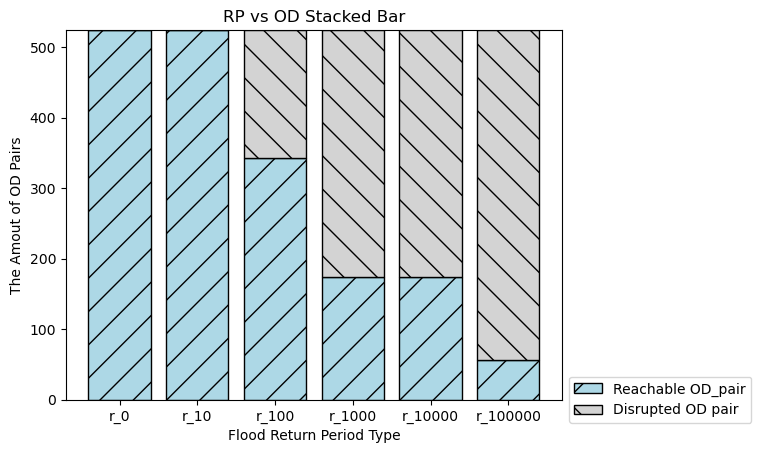

In [214]:
# Create a graph
fig, ax = plt.subplots()

# Draw a stacked bar chart
ax.bar(list(od_com.scenario), list(od_com.od_amount), label='Reachable OD_pair', color='lightblue', edgecolor='black', hatch='/')  # 用斜线填充
ax.bar(list(od_com.scenario), list(od_com.disrupted_od_amount), bottom=list(od_com.od_amount), label='Disrupted OD pair', color='lightgrey', edgecolor='black', hatch='\\')  # 用反斜线填充

# Set labels and title
ax.set_xlabel('Flood Return Period Type')
ax.set_ylabel('The Amout of OD Pairs')
ax.set_title('RP vs OD Stacked Bar')

# Show legend outside the plot area on the lower right corner
ax.legend(loc='center left', bbox_to_anchor=(1, 0))
# Show graph
plt.show()

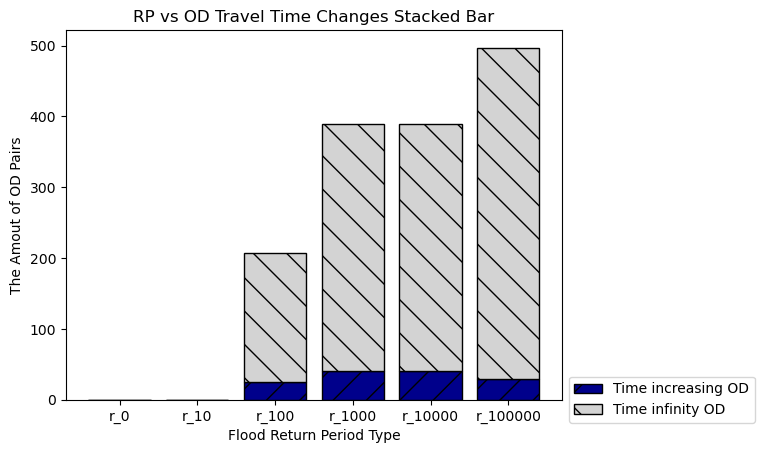

In [215]:
# Create a graph
fig, ax = plt.subplots()

# Draw a stacked bar chart
# ax.bar(list(od_com.scenario), list(od_com.od_amount), label='Time remains OD', color='lightblue', edgecolor='black', hatch='/')  # 用斜线填充
ax.bar(list(od_com.scenario), list(od_com.increasing_time_od_amount	), label='Time increasing OD',color='darkblue', edgecolor='black', hatch='/')  # 用斜线填充
ax.bar(list(od_com.scenario), list(od_com.disrupted_od_amount), bottom=list(od_com.increasing_time_od_amount), label='Time infinity OD', color='lightgrey', edgecolor='black', hatch='\\')  # 用反斜线填充

# Set labels and title
ax.set_xlabel('Flood Return Period Type')
ax.set_ylabel('The Amout of OD Pairs')
ax.set_title('RP vs OD Travel Time Changes Stacked Bar')

# Show legend outside the plot area on the lower right corner
ax.legend(loc='center left', bbox_to_anchor=(1, 0))
# Show graph
plt.show()

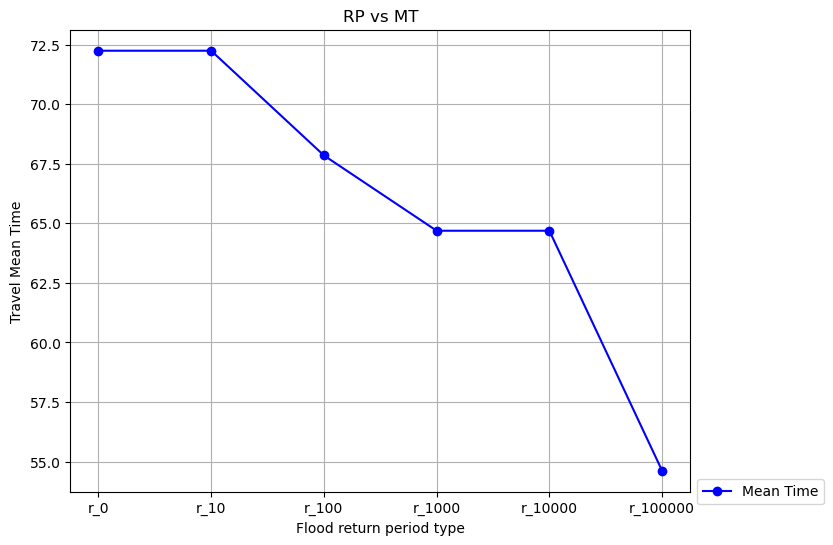

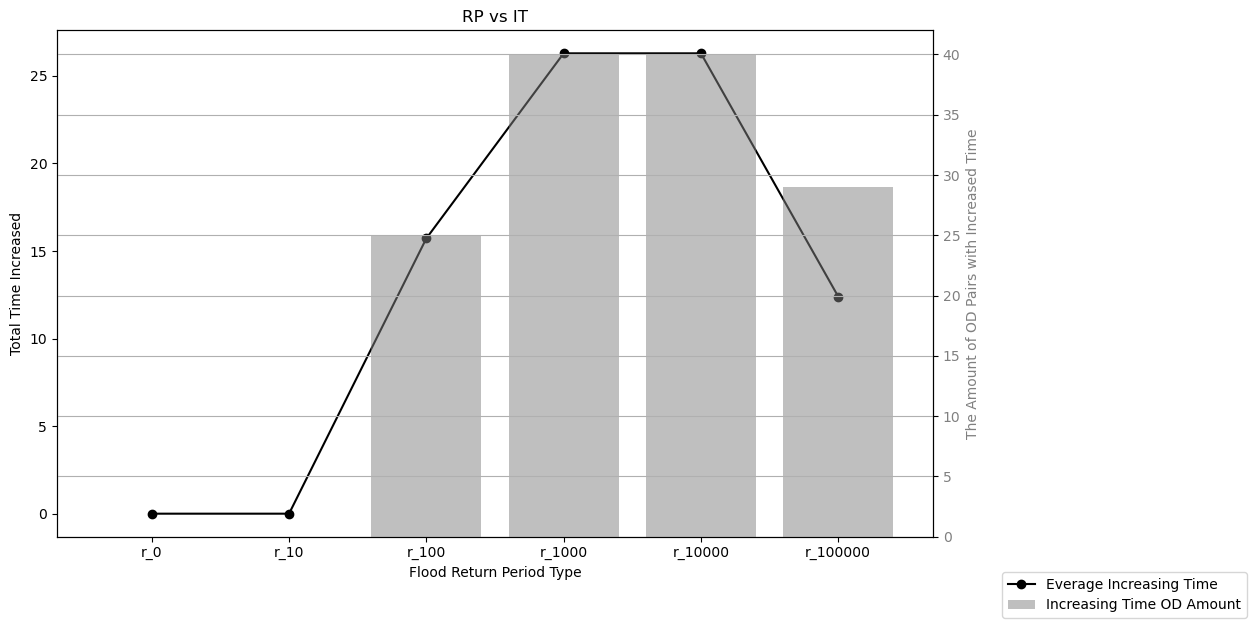

In [216]:
# Draw the first graph: a line graph of mean_time
plt.figure(figsize=(8, 6))
plt.plot(od_com['scenario'], od_com['mean_time'], marker='o', color='blue', label='Mean Time')
plt.xlabel('Flood return period type')
plt.ylabel('Travel Mean Time')
plt.title('RP vs MT')
plt.legend(loc='center left', bbox_to_anchor=(1, 0))
plt.grid(True)
plt.show()

# Draw a second graph: a line graph of increasing_total_time and a bar graph of increasing_time_od_amount
fig, ax1 = plt.subplots(figsize=(10, 6))

# Draw a line chart of increasing_total_time
ax1.plot(od_com['scenario'], od_com['increasing_time_vs_od'], color='black', marker='o', label='Everage Increasing Time')
ax1.set_xlabel('Flood Return Period Type')
ax1.set_ylabel('Total Time Increased', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Create a second Y axis for drawing a bar chart
ax2 = ax1.twinx()
ax2.bar(od_com['scenario'], od_com['increasing_time_od_amount'], color='gray', alpha=0.5, label='Increasing Time OD Amount')
ax2.set_ylabel('The Amount of OD Pairs with Increased Time', color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

# Combine legends
lines_labels = [ax.get_legend_handles_labels() for ax in [ax1, ax2]]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc='center left', bbox_to_anchor=(1, 0))

plt.title('RP vs IT')
plt.grid(True)
plt.tight_layout()  # Adjust the layout to make room for the legend
plt.show()

## Compare changes in all stations

In [217]:
from collections import Counter

node_frequency_dict = {}
for key, values in shortest_ids_dict.items():
    nodes_lists = []
    for od_num, nodes_list in values.items():
        nodes_lists.extend(nodes_list)
    counts = Counter(nodes_lists)
    df = pd.DataFrame(list(counts.items()), columns=['node_id', 'frequency'])
    df = df.sort_values(by='frequency').reset_index(drop=True)
    node_frequency_dict[key] = df
    
node_frequency_dict

{'r_100000':     node_id  frequency
 0       805          1
 1       121          1
 2      1502          1
 3      2624          1
 4      2586          1
 ..      ...        ...
 73     1663         13
 74     2370         19
 75     2724         20
 76     2583         20
 77     2386         20
 
 [78 rows x 2 columns],
 'r_10000':      node_id  frequency
 0       2449          1
 1       2208          1
 2       2589          2
 3       2588          2
 4       2431          2
 ..       ...        ...
 160     2534         46
 161     2539         48
 162     2530         48
 163     2550         51
 164     2481         59
 
 [165 rows x 2 columns],
 'r_1000':      node_id  frequency
 0       2449          1
 1       2208          1
 2       2589          2
 3       2588          2
 4       2431          2
 ..       ...        ...
 160     2534         46
 161     2539         48
 162     2530         48
 163     2550         51
 164     2481         59
 
 [165 rows x 2 columns],

In [218]:
# Count the usage of stations when no flood occurs
# Merge all node IDs into a list
used_stations_amount_list = []
for od_num, id_list in OD_shortest_path_nodes_id.items():
    used_stations_amount_list.extend(id_list)

# Count the usage frequency of nodes
counts = Counter(used_stations_amount_list)
nor_used_station_frequency_df = pd.DataFrame(list(counts.items()), columns=['node_id', 'frequency'])
nor_used_station_frequency_df = nor_used_station_frequency_df.sort_values(by='frequency').reset_index(drop=True)

# Initialize nor_station_df DataFrame
nor_station_df = pd.DataFrame()

# Add data to DataFrame
nor_station_df['scenarios'] = ['r_0']  # Note that it is passed in list form here
nor_station_df['unflooded_stations_amount'] = [len(city_two_layer_network_stations)]
nor_station_df['disrupted_stations_amount'] = [0]
nor_station_df['used_stations_amount'] = [len(nor_used_station_frequency_df)]



# Count the usage of stations when flood occurs
station_com = pd.DataFrame()

for flood_r, dfs in node_frequency_dict.items():
    dfs['scenarios'] = flood_r
    dfs['unflooded_stations_amount'] = len(remained_stations[flood_r])
    dfs['disrupted_stations_amount'] = len(disrupted_stations[flood_r])
    dfs['used_stations_amount'] = len(dfs)
    
    station_com = pd.concat([station_com, dfs], ignore_index=True)
    station_com = station_com[['scenarios', 'unflooded_stations_amount', 'disrupted_stations_amount', 'used_stations_amount']].drop_duplicates(subset='scenarios').reset_index(drop=True)
station_com = station_com.iloc[::-1].reset_index(drop=True)


# Combine them together
station_com = pd.concat([nor_station_df, station_com]).reset_index(drop=True)
station_com

scenarios  unflooded_stations_amount  disrupted_stations_amount  \
0       r_0                        291                          0   
1      r_10                        291                          0   
2     r_100                        279                         12   
3    r_1000                        246                         45   
4   r_10000                        246                         45   
5  r_100000                        206                         85   

   used_stations_amount  
0                   291  
1                   291  
2                   226  
3                   165  
4                   165  
5                    78

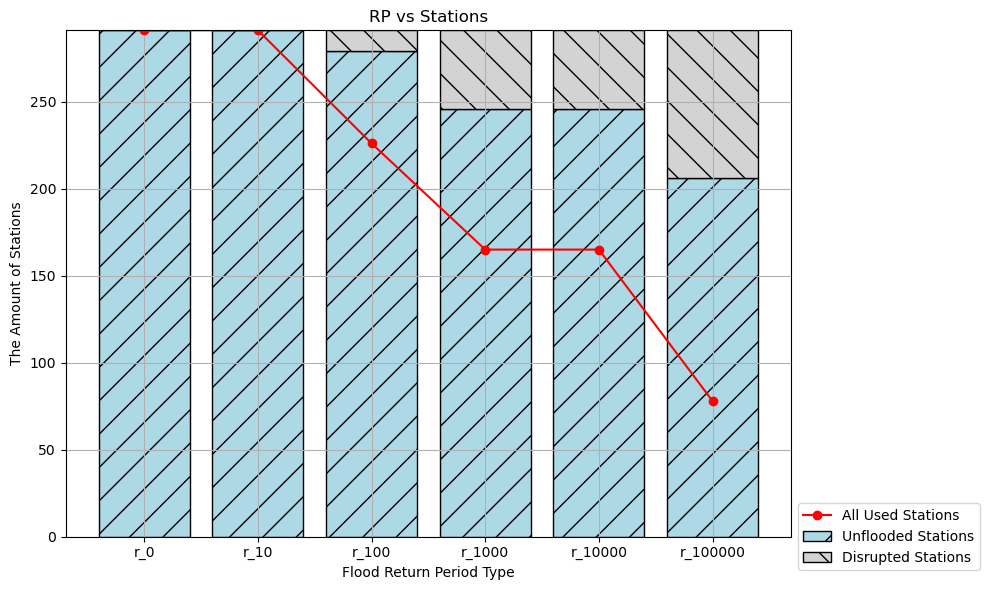

In [219]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Draw a stacked bar chart
ax1.bar(list(station_com.scenarios), list(station_com.unflooded_stations_amount), label='Unflooded Stations', color='lightblue', edgecolor='black', hatch='/')  # 用斜线填充
ax1.bar(list(station_com.scenarios), list(station_com.disrupted_stations_amount), bottom=list(station_com.unflooded_stations_amount), label='Disrupted Stations', color='lightgrey', edgecolor='black', hatch='\\')  
ax1.plot(list(station_com.scenarios), list(station_com.used_stations_amount), color='red', marker='o', label='All Used Stations')
ax1.set_xlabel('Flood Return Period Type')
ax1.set_ylabel('The Amount of Stations', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.legend(loc='center left', bbox_to_anchor=(1, 0))

plt.title('RP vs Stations')
plt.grid(True)
plt.tight_layout()  # Adjust the layout to make room for the legend
plt.show()

In [220]:
for key in node_frequency_dict:
    node_frequency_dict[key] = node_frequency_dict[key].iloc[:, :-4]
node_frequency_dict['r_0'] = nor_used_station_frequency_df
node_frequency_dict

{'r_100000':     node_id  frequency
 0       805          1
 1       121          1
 2      1502          1
 3      2624          1
 4      2586          1
 ..      ...        ...
 73     1663         13
 74     2370         19
 75     2724         20
 76     2583         20
 77     2386         20
 
 [78 rows x 2 columns],
 'r_10000':      node_id  frequency
 0       2449          1
 1       2208          1
 2       2589          2
 3       2588          2
 4       2431          2
 ..       ...        ...
 160     2534         46
 161     2539         48
 162     2530         48
 163     2550         51
 164     2481         59
 
 [165 rows x 2 columns],
 'r_1000':      node_id  frequency
 0       2449          1
 1       2208          1
 2       2589          2
 3       2588          2
 4       2431          2
 ..       ...        ...
 160     2534         46
 161     2539         48
 162     2530         48
 163     2550         51
 164     2481         59
 
 [165 rows x 2 columns],

In [221]:
stations_used_map_dict = {}
for scenario, node_frequency_df in node_frequency_dict.items():
    merged_df = pd.merge(city_two_layer_network_stations, node_frequency_df, left_on='id', right_on='node_id', how='inner')
    stations_used_map_dict[scenario] = merged_df
stations_used_map_dict

{'r_100000':                     geometry    id  degree                       name  \
 0   POINT (4.88954 52.33769)   857       2                Station RAI   
 1   POINT (4.87396 52.33932)   840       2                       Zuid   
 2   POINT (4.85757 52.33848)   835       2            Amstelveenseweg   
 3   POINT (4.83898 52.38904)   121       2         Station Sloterdijk   
 4     POINT (4.8506 52.3951)   805       2                Isolatorweg   
 ..                       ...   ...     ...                        ...   
 73  POINT (4.87719 52.34882)  2424       2  Gerrit van der Veenstraat   
 74  POINT (4.88207 52.35264)  2765       2           Roelof Hartplein   
 75   POINT (4.87964 52.3567)  2373       2              Concertgebouw   
 76  POINT (4.88124 52.35885)  2407       2                Museumplein   
 77  POINT (4.88069 52.36468)  2568       2                Leidseplein   
 
        geo_x      geo_y         coordinate_value  \
 0   4.889539  52.337689    (4.889539, 52.337

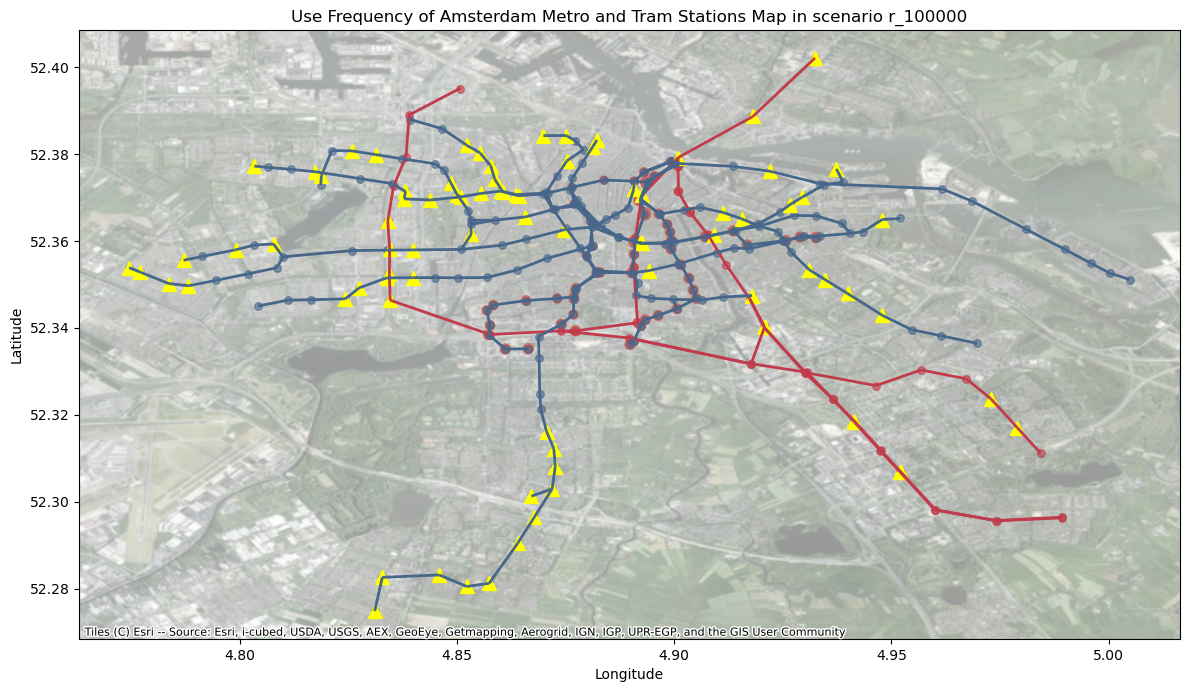

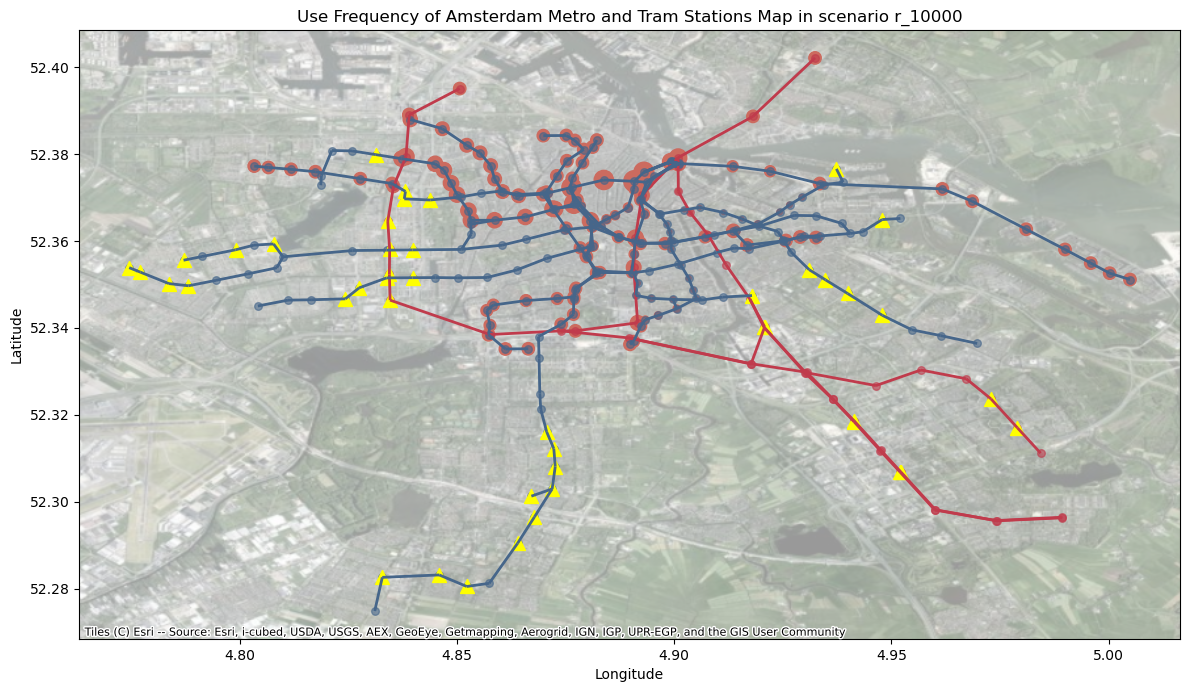

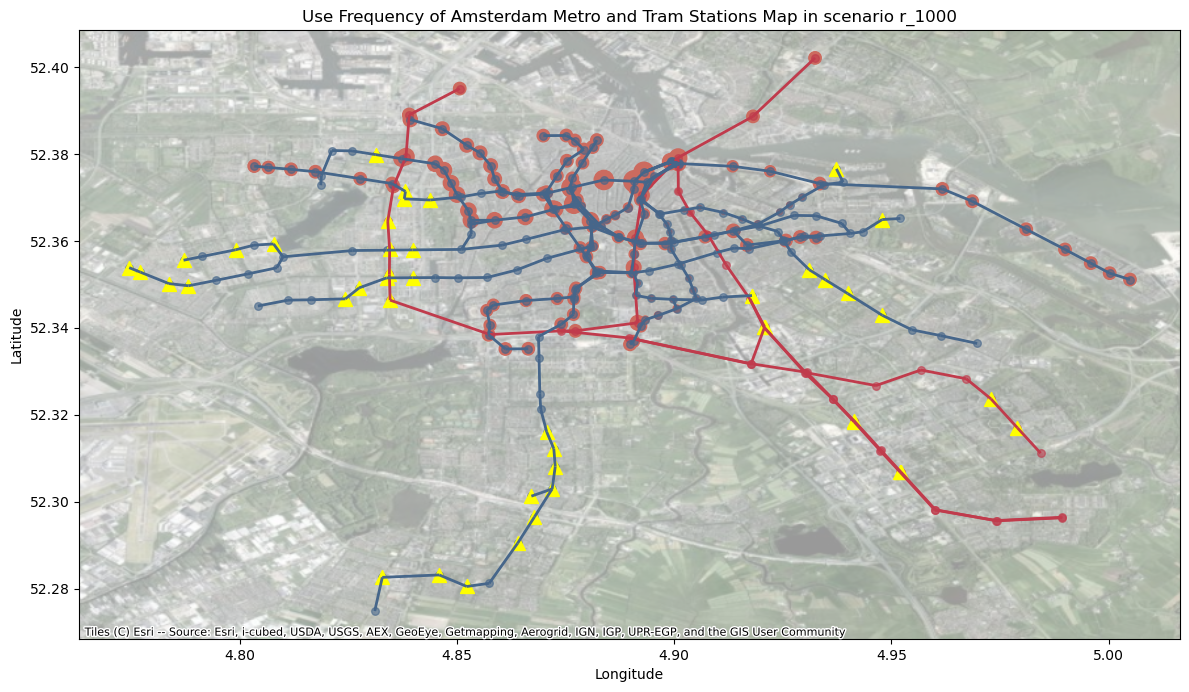

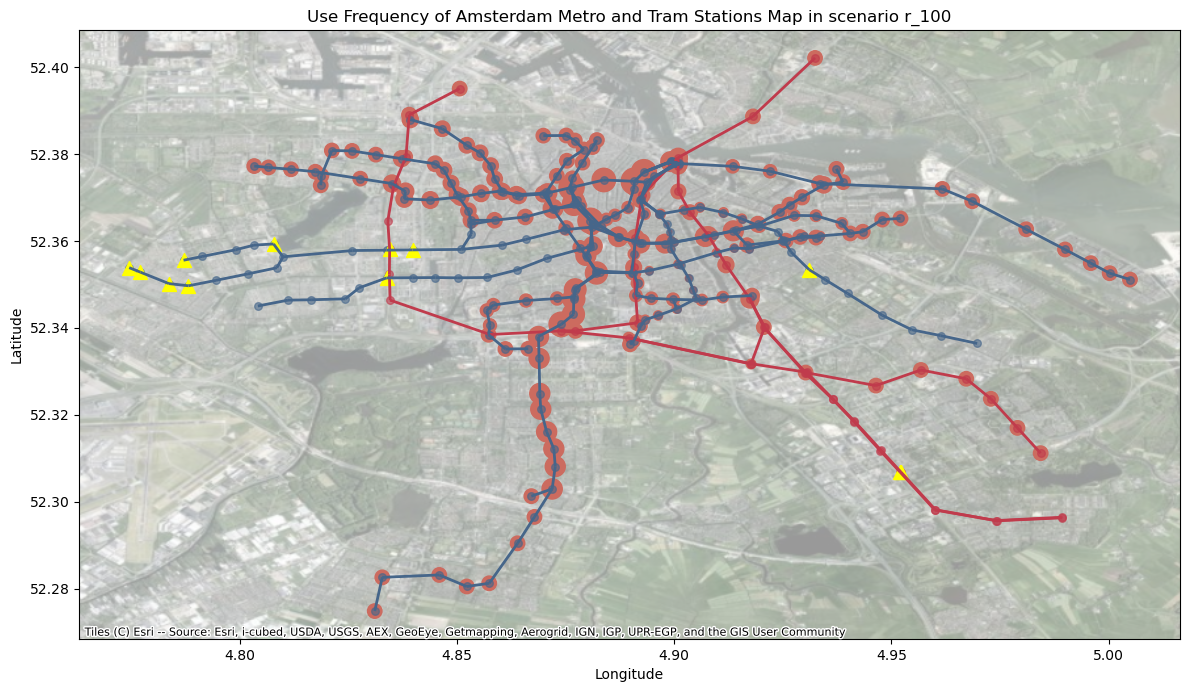

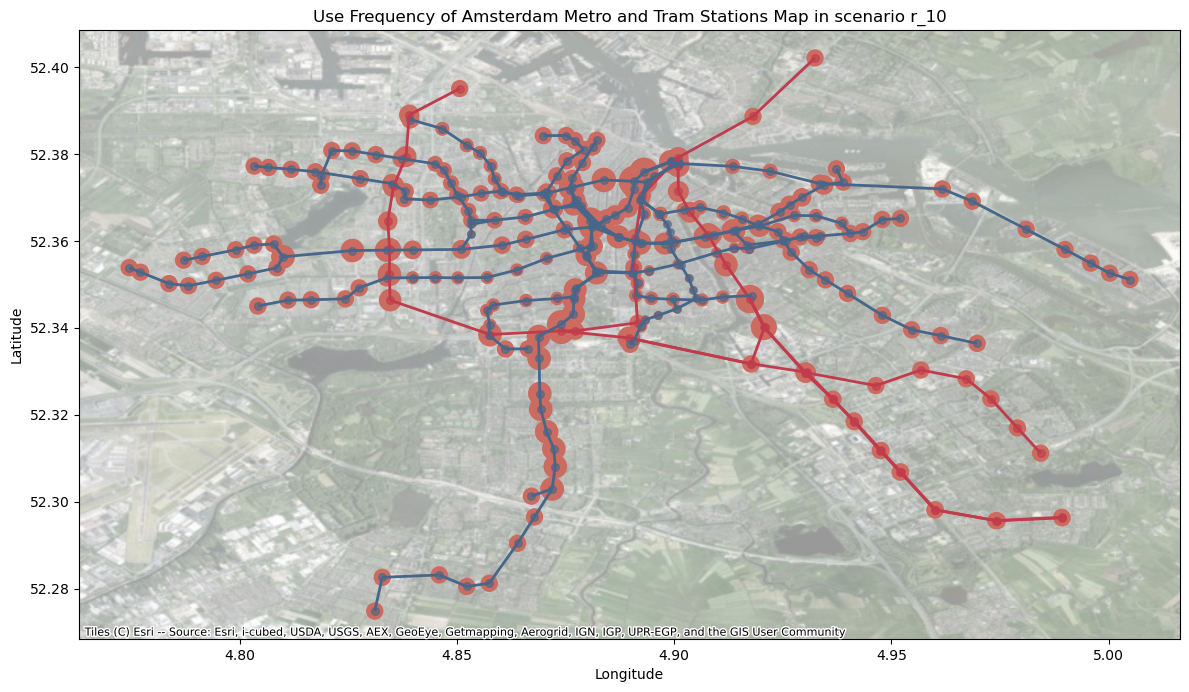

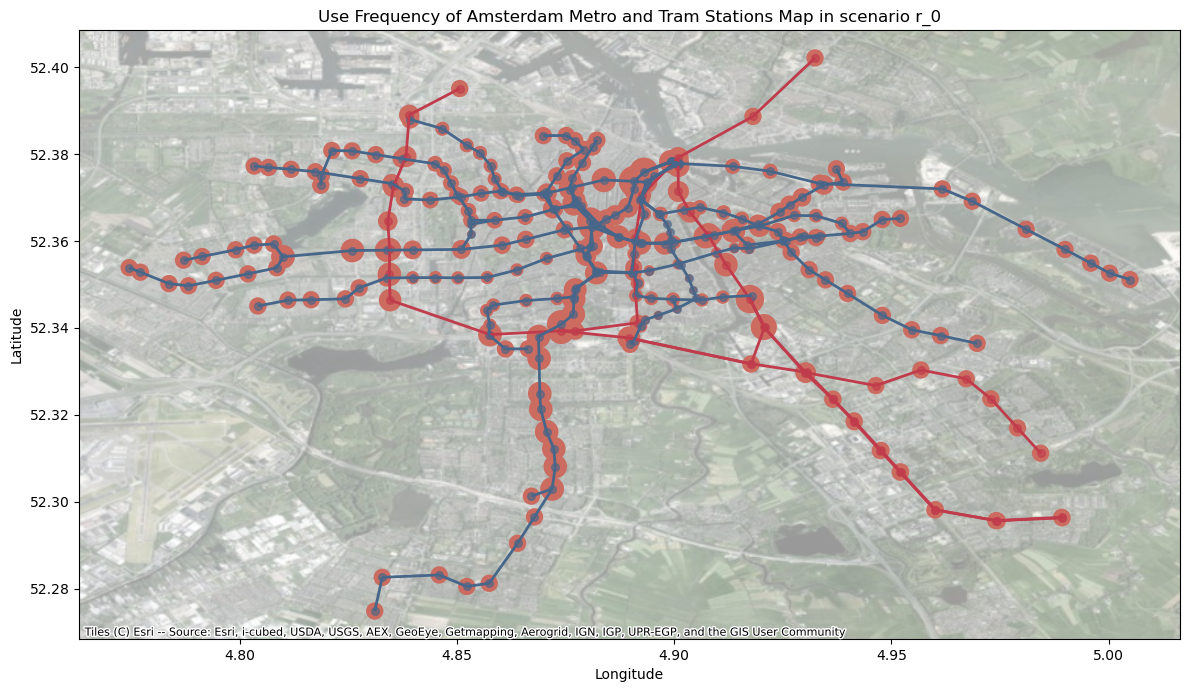

In [222]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import pandas as pd

# 1. Normalize frequency values for shared color mapping
all_frequencies = pd.concat([df['frequency'] for df in stations_used_map_dict.values()])
norm = mcolors.Normalize(vmin=all_frequencies.min(), vmax=all_frequencies.max())

# 2. Loop through scenarios and create maps without legends
for scenario, node_infor_df in stations_used_map_dict.items():
    # Create GeoDataFrames
    city_sub_new_connected_edges_straight_line_gdf = gpd.GeoDataFrame(city_sub_new_connected_edges_straight_line.copy(), geometry='geometry')
    city_tram_new_connected_edges_straight_line_gdf = gpd.GeoDataFrame(city_tram_new_connected_edges_straight_line.copy(), geometry='geometry')
    
    # Create plot
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))  # Adjusted size for better layout
    
    # Plot metro (subway) data
    subway_df = node_infor_df[node_infor_df.route == 'subway']
    subway_sizes = subway_df['frequency'] * 4
    subway_df.plot(ax=ax, markersize=subway_sizes, color='#CC6B5F', edgecolor='#CC6B5F', legend=False)
    
    # Plot tram data
    tram_df = node_infor_df[node_infor_df.route == 'tram']
    tram_sizes = tram_df['frequency'] * 4
    tram_df.plot(ax=ax, markersize=tram_sizes, color='#CC6B5F', edgecolor='#CC6B5F', legend=False)
    
    # Plot other layers
    city_sub_new_half_stations_straight_line_gdf.plot(color='#C03B4C', alpha=0.6, ax=ax, markersize=30, label='Subway Stations')
    city_tram_new_half_stations_straight_line_gdf.plot(color='#46668A', alpha=0.6, ax=ax, markersize=30, label='Tram Stations')
    city_sub_new_connected_edges_straight_line_gdf.plot(color='#C03B4C', ax=ax, linestyle='-', linewidth=2, label='Subway Lines')
    city_tram_new_connected_edges_straight_line_gdf.plot(color='#46668A', ax=ax, linestyle='-', linewidth=2, label='Tram Lines')
    # city_sub_new_connected_edges_straight_line_gdf.plot(color='red', alpha=0.4, ax=ax, linestyle='-', linewidth=2, label='Subway Lines')
    # city_tram_new_connected_edges_straight_line_gdf.plot(color='blue', alpha=0.4, ax=ax, linestyle='-', linewidth=2, label='Tram Lines')

    # Plot disrupted stations on top
    if scenario != 'r_0' and scenario != 'r_10':
        dis_station_gdf = gpd.GeoDataFrame(disrupted_stations[scenario].copy(), geometry='geometry')
        dis_station_gdf.plot(color='#FFFF00', ax=ax, markersize=100, marker='^')
    
    # Add basemap
    metro_lines = gpd.read_file("./Metro lines.GPKG")
    ctx.add_basemap(ax=ax, crs=metro_lines.crs.to_string(), source=ctx.providers.Esri.WorldImagery, alpha=0.4)
    
    # Set title and labels
    ax.set_title(f'Use Frequency of Amsterdam Metro and Tram Stations Map in scenario {scenario}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

plt.show()

## Create Connecting Edges in 300m between Metro and Tram

In [118]:
buffer_radius = 300

In [119]:
sub_new_stations_buffer_geometry = new_nodes_buffer(city_sub_new_half_stations_straight_line_df,buffer_radius)
sub_new_stations_buffer_geometry

geometry   id  degree  \
0    POINT (555390.8842695578 6853898.051924179)  328       2   
1     POINT (553703.1694696408 6853757.86095247)  855       2   
2    POINT (552158.7451182732 6854212.079810633)  854       2   
3   POINT (551268.5008865013 6855802.6299998835)  810       2   
4    POINT (550766.2941357364 6856701.527688845)  809       2   
5    POINT (550073.8757710531 6857940.867237858)  808       2   
6    POINT (549535.3566023917 6858849.747531932)  852       2   
7    POINT (548855.6731874552 6859975.823104483)  828       2   
8    POINT (547425.4292377941 6860337.250530283)  838       2   
9     POINT (544300.991693852 6861415.781777877)  857       2   
10   POINT (542567.1127011032 6861713.358806675)  840       2   
11   POINT (540742.3190802236 6861559.002901717)  835       2   
12   POINT (538182.3270143489 6863000.593051337)  841       2   
13    POINT (538163.0576104926 6864083.50866388)   19       2   
14   POINT (538170.3713010377 6865128.310398296)  843       2   
15   POINT (538122.2367532187 6866319.506687389)  848       2   
16   POINT (538270.2471481774 6867775.387160625)  846       2   
17   POINT (538589.6338992123 6869027.537464746)  844       2   
18   POINT (538672.6337115478 6870776.420804021)  121       2   
19   POINT (539965.8544999914 6871882.875834238)  805       2   
20   POINT (545562.1969967436 6868645.715657004)  731       2   
21   POINT (545569.9114374554 6867564.283310383)  867       2   
22   POINT (545866.9341027902 6866691.428179977)  459       2   
23   POINT (546339.0511951934 6865720.341024122)  460       2   
24  POINT (546789.6836258738 6864490.1202636715)  260       2   
25   POINT (547403.1208118391 6863046.022174509)  819       2   
26    POINT (547780.994823337 6861879.615376292)  831       2   
27   POINT (547432.3199142742 6860323.588092956)  837       2   
28   POINT (549072.4790277241 6873169.820906038)  630       2   
29   POINT (547481.6567125937 6870714.531963056)  818       2   
30   POINT (545563.2990597024 6868983.734081826)  816       2   
31   POINT (544637.7220215526 6867402.978026113)  813       2   
32   POINT (544468.8503540193 6865606.813013325)  861       2   
33   POINT (544424.4004813455 6864380.473447215)  863       2   
34   POINT (544526.0240444907 6862051.560162962)  860       2   
35   POINT (542931.0495123537 6861712.593578889)  180       3   
36    POINT (547760.256002202 6861871.616762494)  830       2   
37    POINT (548831.7061010874 6859963.56389288)  826       2   
38   POINT (550631.7422672147 6859417.783746803)  811       2   
39   POINT (551785.6467129305 6860071.747980665)  822       2   
40   POINT (552946.8648491914 6859703.574633856)   54       2   
41   POINT (553579.2374805408 6858863.571390007)   56       2   
42   POINT (554260.5572919919 6857643.484120411)  812       2   
43   POINT (554854.0905530034 6856584.175521632)   61       2   
44   POINT (548813.3606490047 6859952.160839099)  825       2   
45   POINT (549523.9908823817 6858842.917571281)  851       2   
46   POINT (550076.3359317997 6857895.375833282)  856       2   
47   POINT (550741.5923407294 6856687.889622317)  814       2   
48   POINT (551254.2853875268 6855788.155963545)  850       2   
49   POINT (552139.9321243291 6854204.343641654)  853       2   
50   POINT (553745.1591815681 6853750.562060571)  144       2   
51    POINT (555406.224095389 6853873.369981886)  323       2   

                   name     geo_x      geo_y         coordinate_value  \
0                  Gein  4.989161  52.296407  (4.9891612, 52.2964067)   
1            Reigersbos  4.974000  52.295637  (4.9740002, 52.2956365)   
2           Holendrecht  4.960126  52.298132  (4.9601264, 52.2981319)   
3             Bullewijk  4.952129  52.306869   (4.9521292, 52.306869)   
4         Bijlmer ArenA  4.947618  52.311806   (4.9476178, 52.311806)   
5           Strandvliet  4.941398  52.318612  (4.9413977, 52.3186119)   
6          Duivendrecht  4.936560  52.323602  (4.9365601, 52.3236024)   
7       Va

In [120]:
city_tram_new_stations_ftn = add_footnote_to_new_nodes(city_tram_new_half_stations_straight_line_df)
city_tram_new_stations_ftn

geometry_tram  id_tram  degree_tram  \
0    POINT (549095.9451763834 6865626.846179629)     2209            2   
1    POINT (548687.3358534776 6865651.436549241)     2371            2   
2    POINT (548326.7386269509 6865502.838217197)     2474            2   
3    POINT (547329.2380657996 6865312.719471466)     2480            2   
4     POINT (546978.5928017499 6865909.64907751)     2466            2   
..                                           ...      ...          ...   
234  POINT (537815.5626880322 6869108.306275565)     2526            2   
235  POINT (537206.7563928838 6869264.904153384)     2533            2   
236  POINT (536688.9760453572 6869280.824895416)     2528            2   
237  POINT (536420.8964476287 6868228.609973954)     2509            2   
238  POINT (536404.3098435005 6867823.395916868)     1090            2   

                     name_tram  geo_x_tram  geo_y_tram  \
0           Muiderpoortstation    4.932613   52.360796   
1                 Dapperstraat    4.928942   52.360931   
2               Linnaeusstraat    4.925703   52.360116   
3                    Beukenweg    4.916742   52.359073   
4    Korte 's-Gravesandestraat    4.913592   52.362348   
..                         ...         ...         ...   
234    Burgemeester Fockstraat    4.831279   52.379891   
235   Burgemeester Eliasstraat    4.825810   52.380750   
236              Plein '40-'45    4.821159   52.380837   
237   Burgemeester Roëllstraat    4.818751   52.375067   
238                 Sloterpark    4.818602   52.372845   

       coordinate_value_tram  \
0    (4.9326128, 52.3607965)   
1    (4.9289422, 52.3609314)   
2    (4.9257029, 52.3601162)   
3    (4.9167422, 52.3590732)   
4    (4.9135923, 52.3623479)   
..                       ...   
234  (4.8312794, 52.3798913)   
235    (4.8258104, 52.38075)   
236  (4.8211591, 52.3808373)   
237  (4.8187509, 52.3750672)   
238  (4.8186019, 52.3728449)   

                                  route_name_list_tram route_tram  ref_tram  \
0    Tram 1: Amsterdam Muiderpoortstation =>Amsterd...       tram      1, 3   
1    Tram 1: Amsterdam Muiderpoortstation =>Amsterd...       tram      1, 3   
2    Tram 1: Amsterdam Muiderpoortstation =>Amsterd...       tram      1, 3   
3    Tram 1: Amsterdam Muiderpoortstation =>Amsterd...       tram      1, 3   
4    Tram 1: Amsterdam Muiderpoortstation =>Amsterd...       tram  1, 19, 7   
..                                                 ...        ...       ...   
234  Tram 7: Amsterdam Azartplein => Amsterdam Slot...       tram         7   
235  Tram 7: Amsterdam Azartplein => Amsterdam Slot...       tram         7   
236  Tram 7: Amsterdam Azartplein => Amsterdam Slot...       tram         7   
237  Tram 7: Amsterdam Azartplein => Amsterdam Slot...       tram         7   
238  Tram 7: Amsterdam Azartplein => Amsterdam Slot...       tram         7   

    transfer_tram  
0            1, 3  
1            1, 3  
2            1, 3  
3            1, 3  
4        1, 19, 7  
..            ...  
234          None  
235          None  
236          None  
237          None  
238          None  

[239 rows x 11 columns]

In [121]:
def transfer_A_to_B_oneway(A_new_nodes_buffer_geometry,B_new_nodes_ftn):
    transfer_stations_A_to_B = pd.DataFrame()
    
    for index, row in A_new_nodes_buffer_geometry.iterrows():
        each_transfer_stations_df = B_new_nodes_ftn[row['buffer_geometry'].intersects(B_new_nodes_ftn.iloc[:, 0])]
        
        if not each_transfer_stations_df.empty:
            replicated_row = pd.concat([row] * len(each_transfer_stations_df), axis=1).transpose()
            replicated_row.reset_index(drop=True, inplace=True)  # Reset the index
            each_transfer_stations_df.reset_index(drop=True, inplace=True)  # Reset the index
            co_df = pd.concat([replicated_row,each_transfer_stations_df], axis=1)
            transfer_stations_A_to_B = pd.concat([transfer_stations_A_to_B,co_df])

    transfer_stations_A_to_B = transfer_stations_A_to_B.sort_values(by='name')
    transfer_stations_A_to_B.reset_index(drop=True,inplace=True)
       

    return transfer_stations_A_to_B

In [122]:
transfer_stations_sub_to_tram_oneway = transfer_A_to_B_oneway(sub_new_stations_buffer_geometry,city_tram_new_stations_ftn)
transfer_stations_sub_to_tram_oneway

geometry   id degree  \
0   POINT (547403.1208118391 6863046.022174509)  819      2   
1   POINT (540742.3190802236 6861559.002901717)  835      2   
2   POINT (545562.1969967436 6868645.715657004)  731      2   
3   POINT (545563.2990597024 6868983.734081826)  816      2   
4   POINT (545563.2990597024 6868983.734081826)  816      2   
5   POINT (545563.2990597024 6868983.734081826)  816      2   
6   POINT (545563.2990597024 6868983.734081826)  816      2   
7   POINT (545563.2990597024 6868983.734081826)  816      2   
8   POINT (545563.2990597024 6868983.734081826)  816      2   
9   POINT (545562.1969967436 6868645.715657004)  731      2   
10  POINT (545562.1969967436 6868645.715657004)  731      2   
11  POINT (545562.1969967436 6868645.715657004)  731      2   
12  POINT (545563.2990597024 6868983.734081826)  816      2   
13  POINT (545563.2990597024 6868983.734081826)  816      2   
14  POINT (545562.1969967436 6868645.715657004)  731      2   
15  POINT (545562.1969967436 6868645.715657004)  731      2   
16  POINT (545562.1969967436 6868645.715657004)  731      2   
17  POINT (545562.1969967436 6868645.715657004)  731      2   
18  POINT (544424.4004813455 6864380.473447215)  863      2   
19  POINT (544424.4004813455 6864380.473447215)  863      2   
20  POINT (538589.6338992123 6869027.537464746)  844      2   
21  POINT (544526.0240444907 6862051.560162962)  860      2   
22  POINT (544526.0240444907 6862051.560162962)  860      2   
23   POINT (538163.0576104926 6864083.50866388)   19      2   
24  POINT (538270.2471481774 6867775.387160625)  846      2   
25  POINT (538170.3713010377 6865128.310398296)  843      2   
26  POINT (544637.7220215526 6867402.978026113)  813      2   
27  POINT (544637.7220215526 6867402.978026113)  813      2   
28   POINT (544300.991693852 6861415.781777877)  857      2   
29   POINT (544300.991693852 6861415.781777877)  857      2   
30  POINT (538672.6337115478 6870776.420804021)  121      2   
31  POINT (544468.8503540193 6865606.813013325)  861      2   
32  POINT (544468.8503540193 6865606.813013325)  861      2   
33  POINT (544468.8503540193 6865606.813013325)  861      2   
34  POINT (545866.9341027902 6866691.428179977)  459      2   
35  POINT (546339.0511951934 6865720.341024122)  460      2   
36  POINT (546339.0511951934 6865720.341024122)  460      2   
37  POINT (542567.1127011032 6861713.358806675)  840      2   

                   name     geo_x      geo_y         coordinate_value  \
0         Amstelstation  4.917406  52.346636  (4.9174059, 52.3466361)   
1       Amstelveenseweg  4.857571  52.338475  (4.8575709, 52.3384751)   
2      Centraal Station  4.900869  52.377355  (4.9008686, 52.3773546)   
3      Centraal Station  4.900879  52.379208  (4.9008785, 52.3792082)   
4      Centraal Station  4.900879  52.379208  (4.9008785, 52.3792082)   
5      Centraal Station  4.900879  52.379208  (4.9008785, 52.3792082)   
6      Centraal Station  4.900879  52.379208  (4.9008785, 52.3792082)   
7      Centraal Station  4.900879  52.379208  (4.9008785, 52.3792082)   
8      Centraal Station  4.900879  52.379208  (4.9008785, 52.3792082)   
9      Centraal Station  4.900869  52.377355  (4.9008686, 52.3773546)   
10     Centraal Station  4.900869  52.377355  (4.9008686, 52.3773546)   
11     Centraal Station  4.900869  52.377355  (4.9008686, 52.3773546)   
12     Centraal Station  4.900879  52.379208  (4.9008785, 52.3792082)   
13     Centraal Station  4.900879  52.379208  (4.9008785, 52.3792082)   
14     Centraal Station  4.900869  52.377355  (4.9008686, 52.3773546)   
15     Centraal Station  4.900869  52.377355  (4.9008686, 52.3773546)   
16     Centraal Station  4.900869  52.377355  (4.9008686, 52.3773546)   
17     Centraal Station  4.900869  52.377355  (4.9008686, 52.3773546)   
18              De Pijp  4.890648  52.353958  (4.8906476, 52.3539585)   
19              De Pijp  4.890648  52.353958  (4.8906476, 52.3539585)   
20         De Vlugtlaan  4.838233  52.379448   (

In [123]:
# transfer_stations_sub_to_tram_oneway.loc[:,['name','name_tram']]

In [124]:
def create_connect_edges_oneway(transfer_stations_sub_to_tram):
    
    lines1 = []
    from_id_list1 = []
    to_id_list1 = []


    for index, row in transfer_stations_sub_to_tram.iterrows():
        line = LineString([list(row.iloc[6]), list(row.iloc[18])])
        from_id = row.iloc[1]
        to_id = row.iloc[13]
    
        
        lines1.append(line)
        from_id_list1.append(from_id)
        to_id_list1.append(to_id)

    result_df1 = pd.DataFrame({'geometry': lines1,
                              'from_id':from_id_list1,
                              'to_id':to_id_list1})


    # lines2 = []
    # from_id_list2 = []
    # to_id_list2 = []


    # for index, row in transfer_stations_sub_to_tram.iterrows():
    #     line = LineString([list(row.iloc[18]), list(row.iloc[6])])
    #     from_id = row.iloc[13]
    #     to_id = row.iloc[1]
    
        
    #     lines2.append(line)
    #     from_id_list2.append(from_id)
    #     to_id_list2.append(to_id)

    # result_df2 = pd.DataFrame({'geometry': lines2,
    #                           'from_id':from_id_list2,
    #                           'to_id':to_id_list2}) 

    # result_df = pd.concat([result_df1,result_df2])
    result_df = result_df1
    result_df['from_to'] = list(zip(result_df.from_id,result_df.to_id))
    result_df['to_from'] = list(zip(result_df.to_id,result_df.from_id))
    return result_df

In [125]:
connect_edges_sub_to_tram_oneway = create_connect_edges_oneway(transfer_stations_sub_to_tram_oneway)
connect_edges_sub_to_tram_oneway

geometry  from_id  to_id  \
0   LINESTRING (4.9174059 52.3466361, 4.9178945 52...      819   2101   
1   LINESTRING (4.8575709 52.3384751, 4.8572486 52...      835   2515   
2   LINESTRING (4.9008686 52.3773546, 4.8993575 52...      731   2178   
3   LINESTRING (4.9008785 52.3792082, 4.8993575 52...      816   2178   
4   LINESTRING (4.9008785 52.3792082, 4.8991546 52...      816   2180   
5   LINESTRING (4.9008785 52.3792082, 4.9003629 52...      816   1544   
6   LINESTRING (4.9008785 52.3792082, 4.8992178 52...      816   2173   
7   LINESTRING (4.9008785 52.3792082, 4.8992878 52...      816   2177   
8   LINESTRING (4.9008785 52.3792082, 4.9009807 52...      816   2776   
9   LINESTRING (4.9008686 52.3773546, 4.9009807 52...      731   2776   
10  LINESTRING (4.9008686 52.3773546, 4.9009769 52...      731   1658   
11  LINESTRING (4.9008686 52.3773546, 4.9003819 52...      731   1359   
12  LINESTRING (4.9008785 52.3792082, 4.9003819 52...      816   1359   
13  LINESTRING (4.9008785 52.3792082, 4.9009769 52...      816   1658   
14  LINESTRING (4.9008686 52.3773546, 4.9003629 52...      731   1544   
15  LINESTRING (4.9008686 52.3773546, 4.8992178 52...      731   2173   
16  LINESTRING (4.9008686 52.3773546, 4.8992878 52...      731   2177   
17  LINESTRING (4.9008686 52.3773546, 4.8991546 52...      731   2180   
18  LINESTRING (4.8906476 52.3539585, 4.8905961 52...      863   2636   
19  LINESTRING (4.8906476 52.3539585, 4.8901771 52...      863   2722   
20  LINESTRING (4.838233 52.3794484, 4.8372054 52....      844   2529   
21  LINESTRING (4.8915605 52.3411785, 4.8922816 52...      860   2628   
22  LINESTRING (4.8915605 52.3411785, 4.893324 52....      860   2627   
23  LINESTRING (4.834401 52.3523291, 4.8337504 52....       19   2551   
24  LINESTRING (4.8353639 52.3725816, 4.8350051 52...      846   2687   
25  LINESTRING (4.8344667 52.3580615, 4.8337835 52...      843   2654   
26  LINESTRING (4.8925639 52.3705391, 4.8921252 52...      813   2583   
27  LINESTRING (4.8925639 52.3705391, 4.892274 52....      813   2584   
28  LINESTRING (4.889539 52.337689, 4.889801 52.33...      857   1663   
29  LINESTRING (4.889539 52.337689, 4.8906393 52.3...      857   2629   
30  LINESTRING (4.8389786 52.3890375, 4.8392172 52...      121   1502   
31  LINESTRING (4.8910469 52.3606866, 4.8921024 52...      861   2467   
32  LINESTRING (4.8910469 52.3606866, 4.8925358 52...      861   2742   
33  LINESTRING (4.8910469 52.3606866, 4.8909623 52...      861   2386   
34  LINESTRING (4.9036061 52.3666363, 4.9022284 52...      459   2586   
35  LINESTRING (4.9078472 52.3613094, 4.9091584 52...      460   2449   
36  LINESTRING (4.9078472 52.3613094, 4.9071213 52...      460   2448   
37  LINESTRING (4.8739633 52.3393223, 4.8739688 52...      840   2300   

        from_to      to_from  
0   (819, 2101)  (2101, 819)  
1   (835, 2515)  (2515, 835)  
2   (731, 2178)  (2178, 731)  
3   (816, 2178)  (2178, 816)  
4   (816, 2180)  (2180, 816)  
5   (816, 1544)  (1544, 816)  
6   (816, 2173)  (2173, 816)  
7   (816, 2177)  (2177, 816)  
8   (816, 2776)  (2776, 816)  
9   (731, 2776)  (2776, 731)  
10  (731, 1658)  (1658, 731)  
11  (731, 1359)  (1359, 731)  
12  (816, 1359)  (1359, 816)  
13  (816, 1658)  (1658, 816)  
14  (731, 1544)  (1544, 731)  
15  (731, 2173)  (2173, 731)  
16  (731, 2177)  (2177, 731)  
17  (731, 2180)  (2180, 731)  
18  (863, 2636)  (2636, 863)  
19  (863, 2722)  (2722, 863)  
20  (844, 2529)  (2529, 844)  
21  (860, 2628)  (2628, 860)  
22  (860, 2627)  (2627, 860)  
23   (19, 2551)   (2551, 19)  
24  (846, 2687)  (2687, 846)  
25  (843, 2654)  (2654, 843)  
26  (813, 2583)  (2583, 813)  
27  (813, 2584)  (2584, 813)  
28  (857, 1663)  (1663, 857)  
29  (857, 2629)  (2629, 857)  
30  (121, 1502)  (1502, 121)  
31  (861, 2467)  (2467, 861)  
32  (861, 2742)  (2742, 861)  
33  (861, 2386)  (2386, 861)  
34  (459, 2586)  (2586, 459)  
35  (460, 2449)  (2449, 460)  
36  (460, 2448)  (2448, 460)  
37  (840, 2300)  (2

In [126]:
start_id_for_connect_edges_sub_to_tram = int(city_tram_new_connected_edges_straight_line['id'].iloc[-1] + 1)
start_id_for_connect_edges_sub_to_tram

2662

In [127]:
connect_edges_sub_to_tram_id_list = [start_id_for_connect_edges_sub_to_tram] + [i for i in range(start_id_for_connect_edges_sub_to_tram + 1, start_id_for_connect_edges_sub_to_tram + len(connect_edges_sub_to_tram_oneway))]
# connect_edges_sub_to_tram_id_list

In [128]:
connect_edges_sub_to_tram_oneway['id'] = connect_edges_sub_to_tram_id_list

# Set weights attribute of connecting edges to a value higher than the maximum value in city_sub_new_edges
# connect_edges_sub_to_tram_oneway['weights'] = city_sub_new_edges.sort_values(by='weights').weights.iloc[-1] + city_tram_new_edges.sort_values(by='weights').weights.iloc[-1] + 15/60*25000
# Set time attribute of connecting edges to a value higher than the maximum value in city_sub_new_edges
# connect_edges_sub_to_tram_oneway['time'] =  15
connect_edges_sub_to_tram_oneway['time'] =  16.5

In [129]:
# import geopandas as gpd
# from shapely.geometry import LineString
# from pyproj import Transformer

def project_geometry(geom):
    transformer = Transformer.from_crs("epsg:4326", "epsg:3857", always_xy=True)
    coords = [transformer.transform(x, y) for x, y in geom.coords]
    return LineString(coords)


connect_edges_sub_to_tram_oneway_gdf = gpd.GeoDataFrame(connect_edges_sub_to_tram_oneway.copy(), geometry='geometry', crs="EPSG:4326")

connect_edges_sub_to_tram_oneway_gdf_3857 = connect_edges_sub_to_tram_oneway_gdf.copy()
connect_edges_sub_to_tram_oneway_gdf_3857['geometry'] = connect_edges_sub_to_tram_oneway_gdf_3857['geometry'].apply(lambda geom: project_geometry(geom))


connect_edges_sub_to_tram_oneway['distance'] = connect_edges_sub_to_tram_oneway_gdf_3857['geometry'].length

In [130]:
connect_edges_sub_to_tram_oneway

geometry  from_id  to_id  \
0   LINESTRING (4.9174059 52.3466361, 4.9178945 52...      819   2101   
1   LINESTRING (4.8575709 52.3384751, 4.8572486 52...      835   2515   
2   LINESTRING (4.9008686 52.3773546, 4.8993575 52...      731   2178   
3   LINESTRING (4.9008785 52.3792082, 4.8993575 52...      816   2178   
4   LINESTRING (4.9008785 52.3792082, 4.8991546 52...      816   2180   
5   LINESTRING (4.9008785 52.3792082, 4.9003629 52...      816   1544   
6   LINESTRING (4.9008785 52.3792082, 4.8992178 52...      816   2173   
7   LINESTRING (4.9008785 52.3792082, 4.8992878 52...      816   2177   
8   LINESTRING (4.9008785 52.3792082, 4.9009807 52...      816   2776   
9   LINESTRING (4.9008686 52.3773546, 4.9009807 52...      731   2776   
10  LINESTRING (4.9008686 52.3773546, 4.9009769 52...      731   1658   
11  LINESTRING (4.9008686 52.3773546, 4.9003819 52...      731   1359   
12  LINESTRING (4.9008785 52.3792082, 4.9003819 52...      816   1359   
13  LINESTRING (4.9008785 52.3792082, 4.9009769 52...      816   1658   
14  LINESTRING (4.9008686 52.3773546, 4.9003629 52...      731   1544   
15  LINESTRING (4.9008686 52.3773546, 4.8992178 52...      731   2173   
16  LINESTRING (4.9008686 52.3773546, 4.8992878 52...      731   2177   
17  LINESTRING (4.9008686 52.3773546, 4.8991546 52...      731   2180   
18  LINESTRING (4.8906476 52.3539585, 4.8905961 52...      863   2636   
19  LINESTRING (4.8906476 52.3539585, 4.8901771 52...      863   2722   
20  LINESTRING (4.838233 52.3794484, 4.8372054 52....      844   2529   
21  LINESTRING (4.8915605 52.3411785, 4.8922816 52...      860   2628   
22  LINESTRING (4.8915605 52.3411785, 4.893324 52....      860   2627   
23  LINESTRING (4.834401 52.3523291, 4.8337504 52....       19   2551   
24  LINESTRING (4.8353639 52.3725816, 4.8350051 52...      846   2687   
25  LINESTRING (4.8344667 52.3580615, 4.8337835 52...      843   2654   
26  LINESTRING (4.8925639 52.3705391, 4.8921252 52...      813   2583   
27  LINESTRING (4.8925639 52.3705391, 4.892274 52....      813   2584   
28  LINESTRING (4.889539 52.337689, 4.889801 52.33...      857   1663   
29  LINESTRING (4.889539 52.337689, 4.8906393 52.3...      857   2629   
30  LINESTRING (4.8389786 52.3890375, 4.8392172 52...      121   1502   
31  LINESTRING (4.8910469 52.3606866, 4.8921024 52...      861   2467   
32  LINESTRING (4.8910469 52.3606866, 4.8925358 52...      861   2742   
33  LINESTRING (4.8910469 52.3606866, 4.8909623 52...      861   2386   
34  LINESTRING (4.9036061 52.3666363, 4.9022284 52...      459   2586   
35  LINESTRING (4.9078472 52.3613094, 4.9091584 52...      460   2449   
36  LINESTRING (4.9078472 52.3613094, 4.9071213 52...      460   2448   
37  LINESTRING (4.8739633 52.3393223, 4.8739688 52...      840   2300   

        from_to      to_from    id  time    distance  
0   (819, 2101)  (2101, 819)  2662  16.5  157.119611  
1   (835, 2515)  (2515, 835)  2663  16.5   37.159734  
2   (731, 2178)  (2178, 731)  2664  16.5  246.355406  
3   (816, 2178)  (2178, 816)  2665  16.5  231.608872  
4   (816, 2180)  (2180, 816)  2666  16.5  255.730124  
5   (816, 1544)  (1544, 816)  2667  16.5  254.154370  
6   (816, 2173)  (2173, 816)  2668  16.5  247.840804  
7   (816, 2177)  (2177, 816)  2669  16.5  240.067005  
8   (816, 2776)  (2776, 816)  2670  16.5  275.231879  
9   (731, 2776)  (2776, 731)  2671  16.5   64.245375  
10  (731, 1658)  (1658, 731)  2672  16.5   91.266089  
11  (731, 1359)  (1359, 731)  2673  16.5  112.328583  
12  (816, 1359)  (1359, 816)  2674  16.5  245.913763  
13  (816, 1658)  (1658, 816)  2675  16.5  247.794337  
14  (731, 1544)  (1544, 731)  2676  16.5  106.520426  
15  (731, 2173)  (2173, 731)  2677  16.5  252.349893  
16  (731, 2177)  (2177, 731)  2678  16.5  248.825685  
17  (731, 2180)  (2180, 731)  2679  16.5  254.877626  
18  (863, 2636)  (2636, 863)  2680  16.5  228.382615  
19  (863, 2722)  (2722, 863)  2681  16.5  239.377914  
20  (844, 2529)  (2529, 844)  2682  16.5  

In [131]:
# connect_edges_sub_to_tram_oneway['id'] = connect_edges_sub_to_tram_id_list

# # Set weights attribute of connecting edges to a value higher than the maximum value in city_sub_new_edges
# connect_edges_sub_to_tram_oneway['distance'] = city_sub_new_edges.sort_values(by='weights').weights.iloc[-1] + city_tram_new_edges.sort_values(by='weights').weights.iloc[-1] + 10000000000
# connect_edges_sub_to_tram_oneway['weights'] = city_sub_new_edges.sort_values(by='weights').weights.iloc[-1] + city_tram_new_edges.sort_values(by='weights').weights.iloc[-1] + 10000000000
# # Set time attribute of connecting edges to a value higher than the maximum value in city_sub_new_edges
# connect_edges_sub_to_tram_oneway['time'] = city_sub_new_edges.sort_values(by='time').time.iloc[-1] + city_tram_new_edges.sort_values(by='time').time.iloc[-1] + 1

In [132]:
# connect_edges_sub_to_tram_oneway

In [133]:
# city_sub_new_half_stations_straight_line_df  ### geometry changes into meters	POINT (555390.884 6853898.052)

In [134]:
# city_tram_new_half_stations_straight_line_df  ### geometry changes into meters	POINT (549095.9451763834 6865626.846179629)

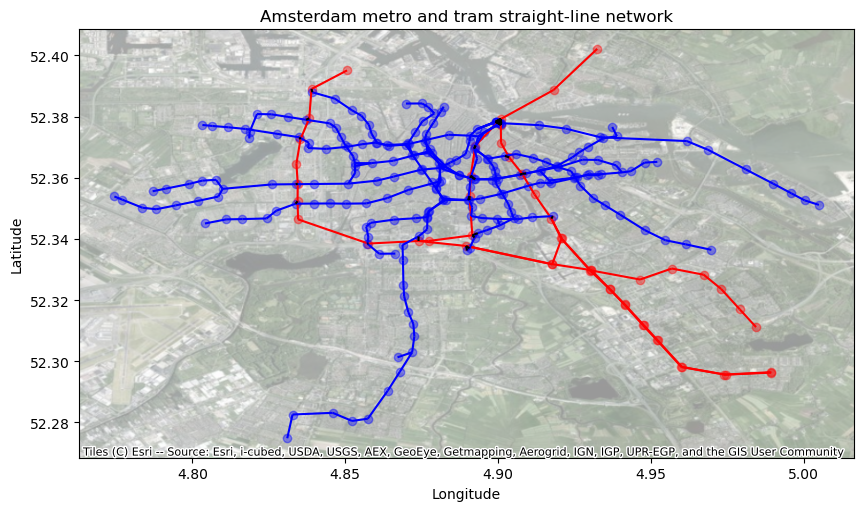

In [135]:
import contextily as ctx
city_sub_new_connected_edges_straight_line_gdf = gpd.GeoDataFrame(city_sub_new_connected_edges_straight_line.copy(), geometry='geometry')
city_tram_new_connected_edges_straight_line_gdf = gpd.GeoDataFrame(city_tram_new_connected_edges_straight_line.copy(), geometry='geometry')
connect_edges_sub_to_tram_oneway_gdf = gpd.GeoDataFrame(connect_edges_sub_to_tram_oneway_gdf.copy(), geometry='geometry')

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

city_sub_new_half_stations_straight_line_gdf.plot(color='red', alpha=0.4, ax=ax, legend=True)
city_sub_new_connected_edges_straight_line_gdf.plot(color='red', ax=ax, legend=True)
city_tram_new_half_stations_straight_line_gdf.plot(color='blue', alpha=0.4, ax=ax, legend=True)
city_tram_new_connected_edges_straight_line_gdf.plot(color='blue', ax=ax, legend=True)
connect_edges_sub_to_tram_oneway_gdf.plot(color='black', ax=ax, legend=True)
metro_lines = gpd.read_file("./Metro lines.GPKG")
ctx.add_basemap(ax=ax, crs=metro_lines.crs.to_string(), source=ctx.providers.Esri.WorldImagery, alpha=0.4)

ax.set_title('Amsterdam metro and tram straight-line network')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')


plt.show()